# Introduction: New York City Taxi Fare Prediction 

The New York City Taxi Fare Prediction dataset is a challenge hosted by Kaggle in partnership with Google Cloud and Coursera. 
This dataset uses a selection from the massive New York City (NYC) Taxi and Limousine Commission (TLC) Yellow Cab dataset that is also publicly available on Big Query.

The goal of this project is to predict the fare amount of a taxi ride given the input features like pickup_datetime, pickup/dropoff latitude, pickup/dropoff longitude and number of passengers. This is a Supervised regression machine learning task. 

The details of the project can be found [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction#description).

The dataset for this challenge is huge consisting of 55M rows in the training set and 10k rows in the test set. The dataset can be downloaded from [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data). There are 6 input features and one target variable (fare_amount) in the training data. 

The 6 input Features are:

    pickup_datetime - timestamp value indicating when the taxi ride started.
    pickup_longitude - float for longitude coordinate of where the taxi ride started.
    pickup_latitude - float for latitude coordinate of where the taxi ride started.
    dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
    dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
    passenger_count - integer indicating the number of passengers in the taxi ride.

Target Variable: 
    
    fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set and this is our target variable. 

In this notebook, we have followed a traditional data science project process to address the NYC Taxi Fare Prediction challenge of predicting taxi fare using pickup and dropoff location information.

    We downloaded the data and loaded it into a dataframe (ETL).
    Along the way, we did some exploratory data analysis (EDA).
    We conducted feature engineering.
    We then created models, evaluated their performance, and fine tuned their parameters.
    We discussed and presented our results in the results table. 

The project has been divided into different phases and each phase covers a substantial amount of work.

## Phase 3 Updates:
For **Phase3**, we have experimented with 1 million rows and made use of the entire 55M rows of training dataset for Model Evaluation. Tasks are prefixed with **Phase3** label to identify the tasks done in phase3. The following tasks are performed for this phase:
- Created 3 new features: Boolean feature for airport trips, boolean feature for night and late night trips.
- We clustered our datapoints using KMeans clustering and added those as new features to our dataset.
- Made use of Sequential Backward Selection for feature selection.
- Implemented deep learning model using KerasRegressor.
- Performed hyperparameter tuning using RandomizedCV along with GridSearchCV for our Keras model.
- Evaluated the Keras model with our phase2 best model.
- Submitted the best model to Kaggle and discussed the results.

## Phase2 Updates:
For **Phase2**, we have experimented with 1 million rows and made use of the entire 55M rows of training dataset for Model Evaluation. Tasks are prefixed with **Phase2** label to identify the tasks done in phase2. The following tasks are performed for this phase:
- Remove the geo locations present in water.
- Created new features around distance using Minkowski method using Euclidean and Manhattan formula.
- Performed additional EDA around the distance features and the timestamp related features.
- Removed rows with haversine distances less than 0.05 miles.
- Created features by calculating airport distances and distance to center of New York City.
- Created class for Feature Engineering and Data cleanup.
- Experimented with new algorithms like XGBoost, PolynomialFeatures+Ridge, SGDRegressor.
- Performed hyperparameter tuning using RandomizedCV along with GridSearchCV.
- Wrapped all the preparation and predictor steps in a pipeline.

## Phase1 Updates:
For **Phase1** out of 55M rows, we downsampled and utilized just 1 million rows. This phase covers the following tasks:
- Dropped the missing rows using dropna
- Removed the outliers in all the columns using percentile approach
- Created distance feature from the latitude/longitude columns
- Created features from pickup_datetime column
- Created class for Data cleanup and removal of outliers
- Created class for feature extraction
- Experimented with Linear Regression and Random forest algorithms for model evaluation
- Performed GridSearch and statistical significance tests
- Wrapped all the preparation and predictor steps in a pipeline.
- Submitted the best model to Kaggle and loaded the results in the results table.

# Prepare the notebook

In [1]:
#import dill

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
from xgboost import XGBRegressor
from sklearn.utils import check_array
from sklearn.svm import SVR
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression, Ridge, SGDRegressor, Perceptron
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing as prep
from scipy.stats import randint
from scipy import sparse, stats
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
#import feather
import pandas as pd
import sys
import seaborn as sns
from time import time
import warnings
warnings.simplefilter('ignore')


%matplotlib inline
plt.style.use('seaborn-whitegrid')

C:\Users\Saif\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, x_in, y=None):
        return self

    def transform(self, x_in):
        return x_in[self.attribute_names].values

In [3]:
# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train RMSE", "Test RMSE", "p-value",
                                "t-stat", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Load Data

## Training Data

In [6]:
data = pd.read_csv('data/train.csv', parse_dates=["pickup_datetime"])

In [7]:
import feather
path = 'data/data.feather'
feather.write_dataframe(data, path)

In [8]:
data.shape

(55423856, 8)

In [9]:
df = feather.read_dataframe('data/data.feather')

In [10]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 3.3+ GB


In [12]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
data.isnull().sum()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [14]:
sampletrain = data.sample(10000)
sampletrain50k = data.sample(50000)
sampletrain100k = data.sample(100000)
sampletrain500k = data.sample(500000)
sampletrain1m = data.sample(1000000)

In [15]:
feather.write_dataframe(sampletrain, 'data/sampletrain.feather')
feather.write_dataframe(sampletrain50k, 'data/sampletrain50k.feather')
feather.write_dataframe(sampletrain100k, 'data/sampletrain100k.feather')
feather.write_dataframe(sampletrain500k, 'data/sampletrain500k.feather')
feather.write_dataframe(sampletrain1m, 'data/sampletrain1m.feather')

In [16]:
sampletrain50k.to_csv('data/sampletrain50k.csv')
sampletrain100k.to_csv('data/sampletrain100k.csv')
sampletrain500k.to_csv('data/sampletrain500k.csv')
sampletrain1m.to_csv('data/sampletrain1m.csv')

## Test Data

In [4]:
test = pd.read_csv('data/test.csv', parse_dates=["pickup_datetime"])

In [18]:
test.shape

(9914, 7)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 542.2+ KB


In [20]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [21]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


# Exploratory Data Analysis and Preprocessing

## Downsample the data so that we can experiment more easily

Let's downsample the data by taking a random sample of 1million records from the training sets.

In [4]:
sampletrain = pd.read_csv('data/sampletrain1m.csv',
                          parse_dates=["pickup_datetime"])

In [5]:
sampletrain.shape

(1000000, 9)

In [6]:
sampletrain.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

Remove the unnecessary columns from the dataset

In [7]:
sampletrain = sampletrain[['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
                           'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount']]

In [8]:
sampletrain.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2014-05-16 09:28:00,-73.938528,40.805310,-73.870817,40.773962,1,24.33
1,2011-10-14 15:21:55,0.000000,0.000000,0.000000,0.000000,1,12.90
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.50
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.50
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.30


## Data Quality Check

In [9]:
sampletrain.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1000000.000000,1000000.000000,999996.000000,999996.000000,1000000.000000,1000000.000000
mean,-72.494666,39.919985,-72.498725,39.912088,1.686277,11.336244
std,12.200565,11.563661,13.226220,11.549880,1.325450,9.721400
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,-60.000000
25%,-73.992062,40.734955,-73.991379,40.734065,1.000000,6.000000
50%,-73.981814,40.752643,-73.980141,40.753183,1.000000,8.500000
75%,-73.967095,40.767075,-73.963622,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


Looking at the statistics above, we see that there are outliers in all the columns. Fare_amount cannot be negative, and passenger_count cannot be 208. The latitude and longitude columns are also out of range. The valid latitude values should be between -90/+90 and valid longitude values should be between -180/+180. We need a way to handle these outliers. 

In [10]:
sampletrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
pickup_datetime      1000000 non-null datetime64[ns]
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999996 non-null float64
dropoff_latitude     999996 non-null float64
passenger_count      1000000 non-null int64
fare_amount          1000000 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.4 MB


In [11]:
sampletrain.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

Out of 1 million records, we have 4 missing values. The best way would be to drop these missing values since we have enough data for our analysis. 

## Visualize the target column

Let's plot a histogram of the target column.

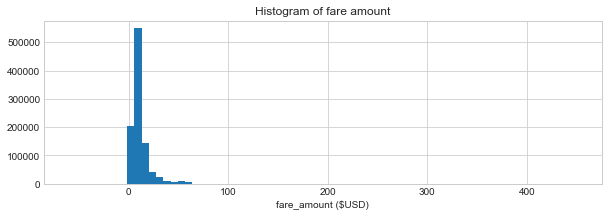

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
sampletrain.fare_amount.hist(bins=70, figsize=(10, 3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram of fare amount')
plt.show()

In [14]:
# Looks like fare is negative - surely a noisy data, let's drop those rows
print('Original number of rows: %d' % len(sampletrain))
df = sampletrain[sampletrain.fare_amount > 0]
print('No. of rows after removing negative fare amount: %d' % len(df))

Original number of rows: 1000000
No. of rows after removing negative fare amount: 999937


In [15]:
# Let's evaluate how many rows have fare greater than 100
df[df.fare_amount > 100].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,-67.276302,37.103753,-66.426684,36.664408,1.385075,137.148866
std,21.131734,11.654829,22.360552,12.342200,0.857034,46.141356
min,-74.435527,0.000000,-74.535058,0.000000,1.000000,100.200000
25%,-73.988071,40.664254,-74.171242,40.690323,1.000000,109.790000
50%,-73.874480,40.750108,-73.963578,40.745679,1.000000,120.000000
75%,-73.783853,40.771797,-73.620004,40.900874,1.000000,150.000000
max,0.000000,41.304762,0.000000,41.304762,6.000000,450.000000


**Out of close to 1 million rows there are 335 rows where fare_amount is more than 100 dollars. To have better picture of fare distribution, let's plot histogram of those rows where fare is less than 100.**

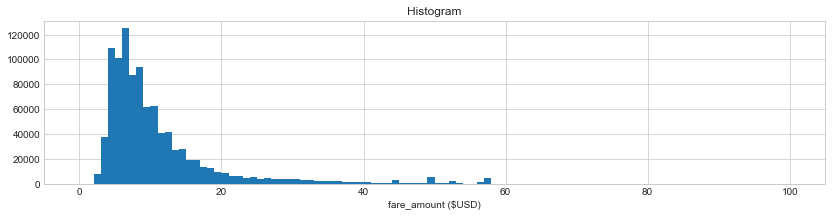

In [16]:
# let's take insight of the Y - Fare
df[df.fare_amount < 100].fare_amount.hist(bins=100, figsize=(14, 3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram')

## Deal with missing values

Here we have enormous amount of data, best approach to deal with missing data would be to drop rows where any column has a null or nan values. 

In [17]:
df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

In [18]:
print('Original number of rows: %d' % len(df))
df = df.dropna(how='any', axis='rows')
print('No. of rows after dropping missing values: %d' % len(df))

Original number of rows: 999937
No. of rows after dropping missing values: 999933


## Remove Outliers

In [19]:
# Lets review the stat after removal of NAN values
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000
mean,-72.494863,39.920092,-72.498928,39.912199,1.686261,11.337401
std,12.200107,11.563771,13.225837,11.549967,1.325425,9.719923
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,0.010000
25%,-73.992063,40.734956,-73.991379,40.734066,1.000000,6.000000
50%,-73.981814,40.752644,-73.980141,40.753183,1.000000,8.500000
75%,-73.967096,40.767075,-73.963623,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


__Looking at the max/min of all the columns, looks like we have outliers on each column. Example, passenger count cannot be 208. To remove the outliers, we will adopt the percentile approach to see if we can filter data with valid range of values.__

__First let's take a look at middle 98 percentile of data.__

In [20]:
low = .01
high = .99
quant_df = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.01        -74.014264         0.000000         -74.015237          0.000000   
0.99          0.000000        40.806813           0.000000         40.830765   

      passenger_count  fare_amount  
0.01              1.0          3.3  
0.99              6.0         52.5  


We still see outliers in the latitude and longitude columns. 

__So, let's now try for middle 96 percentile of data.__ 

In [21]:
low = .02
high = .98
quant_df = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.02        -74.010257        40.566743         -74.011853         40.545672   
0.98        -73.137393        40.799663         -73.137393         40.810127   

      passenger_count  fare_amount  
0.02              1.0         3.50  
0.98              6.0        46.83  


As per http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#GroupRideInformation, the minimum fare for a taxi ride cannot be less than $\$2.5$. The percentile approach gives us minimum fare as $\$3.5$.

In [68]:
print('Original number of rows: %d' % len(df))
data_prepared = df[(df.fare_amount >= df.fare_amount.quantile(low))
                   & (df.fare_amount <= df.fare_amount.quantile(high))

                   & (df.pickup_longitude >= df.pickup_longitude.quantile(low))
                   & (df.pickup_longitude <= df.pickup_longitude.quantile(high))

                   & (df.pickup_latitude >= df.pickup_latitude.quantile(low))
                   & (df.pickup_latitude <= df.pickup_latitude.quantile(high))

                   & (df.dropoff_longitude >= df.dropoff_longitude.quantile(low))
                   & (df.dropoff_longitude <= df.dropoff_longitude.quantile(high))

                   & (df.dropoff_latitude >= df.dropoff_latitude.quantile(low))
                   & (df.dropoff_latitude <= df.dropoff_latitude.quantile(high))

                   & (df.passenger_count >= df.passenger_count.quantile(low))
                   & (df.passenger_count <= df.passenger_count.quantile(high))

                   ]
print('Number of rows after removing outliers: %d' % len(data_prepared))

Original number of rows: 999933
Number of rows after removing outliers: 874468


__Data looks much cleaner now so let's apply this filtering.__

In [69]:
# Lets take a look on stat now
data_prepared.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000
mean,-73.976850,40.751310,-73.975418,40.750897,1.690947,10.195427
std,0.029143,0.023090,0.028767,0.026104,1.306218,6.740902
min,-74.010257,40.566809,-74.011853,40.546040,1.000000,3.500000
25%,-73.991890,40.738033,-73.991220,40.737152,1.000000,6.000000
50%,-73.982194,40.753590,-73.980738,40.753860,1.000000,8.100000
75%,-73.969698,40.766690,-73.966862,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Visualize the features 

### Plot a histogram

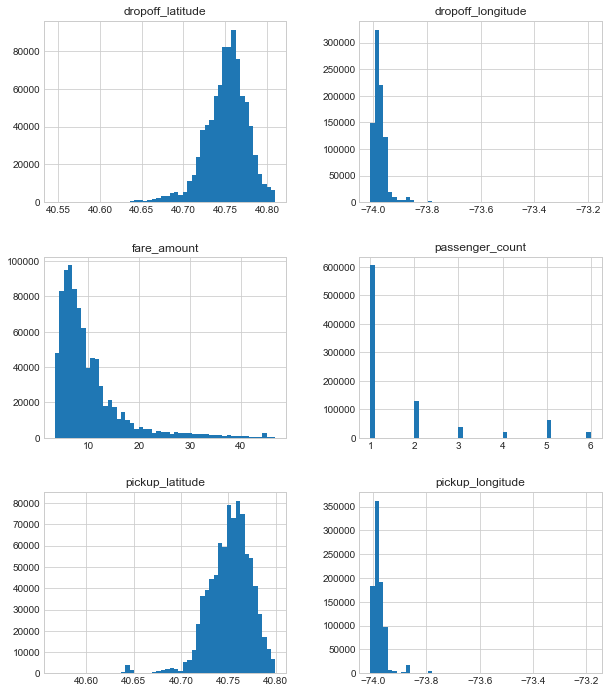

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
data_prepared.hist(bins=50, figsize=(10, 12))
plt.show()

### Plot to see if passenger_count is related to target

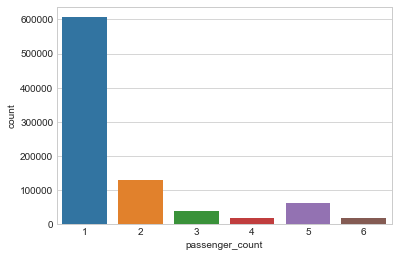

In [71]:
# Count plot on passenger count
sns.countplot(x="passenger_count", data=data_prepared)

In [72]:
passenger_grp = data_prepared.groupby('passenger_count')
passenger_grp['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
1,10.112107,606581
2,10.458585,129920
3,10.351840,38870
4,10.376284,18540
5,10.119960,61854
6,10.814877,18703


Plot to see if there is a correlation between the number of passengers and the fare amount.

Text(0.5,1,'Average fare by Passenger count')

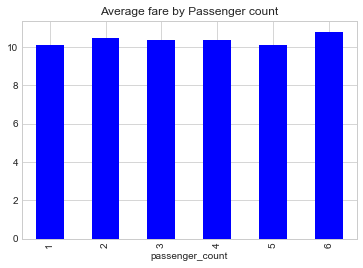

In [73]:
passenger_grp['fare_amount'].mean().plot.bar(color='b')
plt.title('Average fare by Passenger count')

As we can see, there is a small but noticeable difference between the number of passengers and the fare amount. 

### Plot the pick up and drop off locations on NYC Map

We have adopted some of the code for plotting of maps and visualizing the ECDF. Below are the references provided. 

**References:** <p>
- [ref1](https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64)
- [ref2](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration)

In [12]:
# Reference https://aiblog.nl/

# load image of NYC map
# We will use aiblog.nl web service to load the map
nyc = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('download/nyc_-74.5_-72.8_40.5_41.8.png')

# Increasing zoom level to see map in a detailed way
nyc_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('download/nyc_-74.3_-73.7_40.5_40.9.png')

In [13]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    ''' 
    Function to plot the pickup and dropoff locations on the map.
    input: dataframe, coordinates of NYC, map of the NYC
    output: plots the training data on the map

    '''
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude,
                   zorder=1, alpha=alpha, c='y', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude,
                   zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

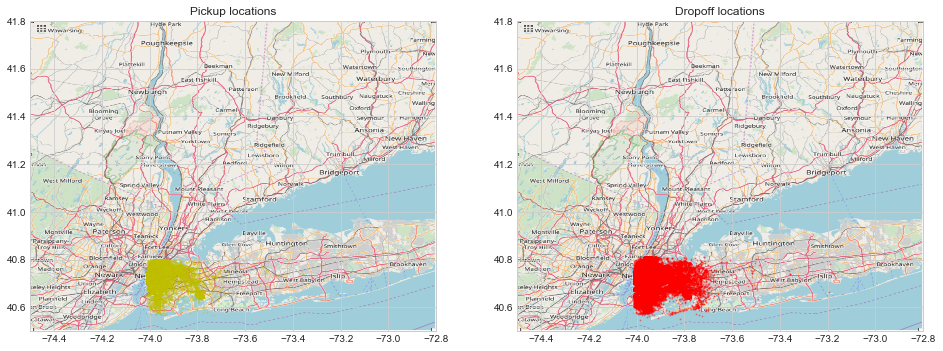

In [76]:
# plot training data on map
plot_on_map(data_prepared, nyc, nyc_map, s=1, alpha=0.3)

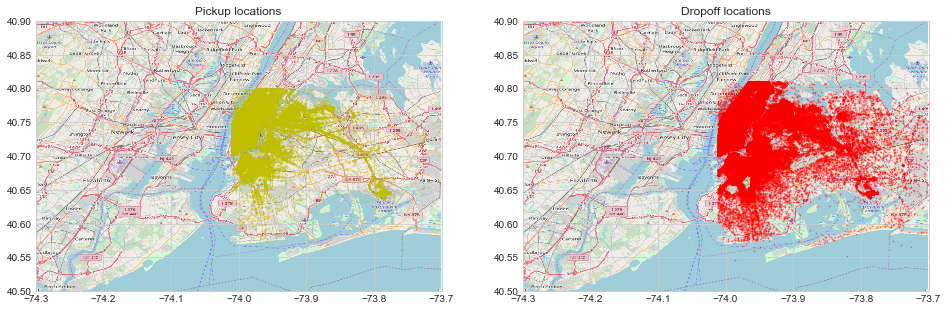

In [77]:
# plot training data on map zoomed in
plot_on_map(data_prepared, nyc_zoom, nyc_map_zoom, s=1, alpha=0.3)

### Remove geolocations present in water

We see few points where pickup and dropoff locations are in water. We need to remove them since they represent noisy data.

#### Steps performed in order to remove water points:

1. Prepare a boolean  map from the NYC map which differentiate between land and water based on threshold. Here we utilized the aiblog.nl web service to download the boolean map
2. Map longitude and latitude coordinates to xy pixel coordinates of our existing image so that we can filter points based on threshold
3. Perform AND operator on pick up and drop off xy coordinates to select only those points where pickup and drop off both are on land

In [14]:
# Reference: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration/


def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')


def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)

    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread(
        'download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:, :, 0] > 0.9

    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude,
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude,
                                        nyc_mask.shape[1], nyc_mask.shape[0], BB)
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

    # return only datapoints on land
    return df[idx]

In [79]:
print('Before removing water geo points: %d' % len(data_prepared))
data_prepared = remove_datapoints_from_water(data_prepared)
print('After removing water geo points: %d' % len(data_prepared))

Before removing water geo points: 874468
After removing water geo points: 874431


#### Lets plot the map now after removing water geo location points

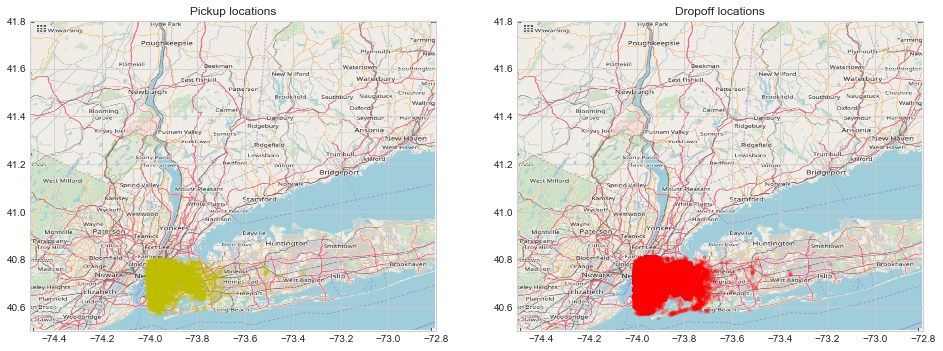

In [80]:
plot_on_map(data_prepared, nyc, nyc_map)

The map shows that there are no longer data points in water. 

### Plot the Empirical cumulative distribution function

The empirical cumulative distribution function provides a graphical representation of the probability distribution of a random vector without implying any prior assumption concerning the form of this distribution. We can view the percentile distribution of the variable and see if there still are any outliers in our target variable. More details about [ECDF](http://openturns.github.io/openturns/master/theory/data_analysis/empirical_cdf.html)

In [81]:
# Declaring CDF fxn


def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)

    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n

    return x, y

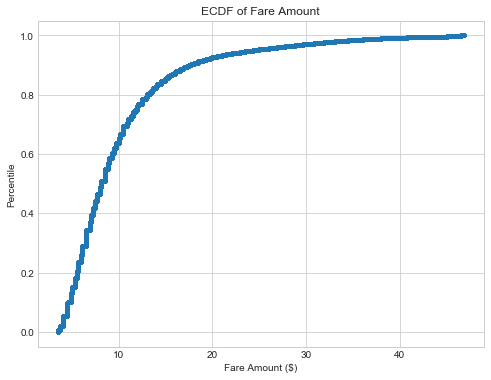

In [82]:
# Visualizing the CDF fxn to check if we still have outliers
xs, ys = ecdf(data_prepared['fare_amount'])
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile')
plt.title('ECDF of Fare Amount')
plt.xlabel('Fare Amount ($)')

__CDF graph shows we have close to 90 percentile of data have fare less than or equals to 20 dollars. Please note this is just for one million sample size.__

__Now all columns look much better, let's write a wrapper class which can be utilized in pipeline.__

In [15]:
sampletrain.shape

(1000000, 7)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.02, high=0.98):
        """

        A class to deal with missing values and remove outliers.

        """
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):

        X = X[X.fare_amount > 0]

        # drop na rows
        X = X.dropna(how='any', axis='rows')

        # remove outliers
        X = X[(X.fare_amount >= X.fare_amount.quantile(self.low))
              & (X.fare_amount <= X.fare_amount.quantile(self.high))

              & (X.pickup_longitude >= X.pickup_longitude.quantile(self.low))
              & (X.pickup_longitude <= X.pickup_longitude.quantile(self.high))

              & (X.pickup_latitude >= X.pickup_latitude.quantile(self.low))
              & (X.pickup_latitude <= X.pickup_latitude.quantile(self.high))

              & (X.dropoff_longitude >= X.dropoff_longitude.quantile(self.low))
              & (X.dropoff_longitude <= X.dropoff_longitude.quantile(self.high))

              & (X.dropoff_latitude >= X.dropoff_latitude.quantile(self.low))
              & (X.dropoff_latitude <= X.dropoff_latitude.quantile(self.high))

              & (X.passenger_count >= X.passenger_count.quantile(self.low))
              & (X.passenger_count <= X.passenger_count.quantile(self.high))

              ]

        # remove water data points
        X = remove_datapoints_from_water(X)

        return X

In [17]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('data_cleaner', DataCleaner(low=0.02, high=0.98)),

])

prepared_data = pipeline.fit_transform(sampletrain)

In [18]:
prepared_data.shape

(874431, 7)

In [19]:
prepared_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [20]:
prepared_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874431.000000,874431.000000,874431.000000,874431.000000,874431.000000,874431.000000
mean,-73.976856,40.751314,-73.975425,40.750901,1.690944,10.195422
std,0.029117,0.023076,0.028741,0.026091,1.306221,6.740948
min,-74.010257,40.570342,-74.011853,40.557236,1.000000,3.500000
25%,-73.991890,40.738035,-73.991220,40.737153,1.000000,6.000000
50%,-73.982195,40.753590,-73.980740,40.753860,1.000000,8.100000
75%,-73.969701,40.766690,-73.966864,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Find Correlation

fare_amount          1.000000
pickup_longitude     0.366144
dropoff_longitude    0.364644
passenger_count      0.012426
pickup_latitude     -0.116981
dropoff_latitude    -0.199089
Name: fare_amount, dtype: float64


Text(0.5,1,'Heatmap of Correlation Matrix')

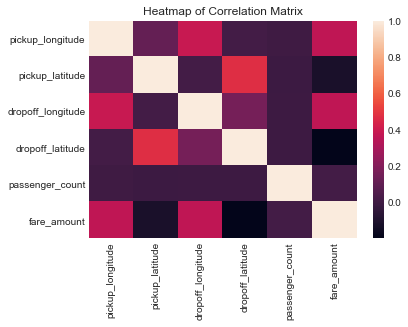

In [89]:
corr_matrix = prepared_data.corr()
print(corr_matrix["fare_amount"].sort_values(ascending=False))
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

As we have a limited set of features, the correlation plot shows that longitude is most highly correlated with the target column.

# Feature Engineering

Let's derive some new features. Feature engineering is the process of creating new features out of an existing dataset and is one of the most important step of the machine learning pipeline. 

## Haversine distance

Since we know that the fare amount of the taxi ride is proportional to the distance traveled, let us derive the distance feature using the pickup and dropoff coordinates. We will use Haversine formula to calculate the distance. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. And the great-circle distance or orthodromic distance is the shortest distance between two points on the surface of a sphere, measured along the surface of the sphere (as opposed to a straight line through the sphere's interior). As we found that, haversine formula is mostly used for navigation purpose, this might give a better approximation of the distance traveled.  More [info here on haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [22]:
# Radius of the earth in kilometers
#R = 6378

# Radius of the earth in miles
R = 3959


def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))

    # Convert to miles
    miles = R * c

    return miles

In [23]:
train_df = prepared_data.copy()

In [24]:
train_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [25]:
train_df['haversine'] = haversine_np(train_df['pickup_longitude'], train_df['pickup_latitude'],
                                     train_df['dropoff_longitude'], train_df['dropoff_latitude'])

In [26]:
train_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340


### Histogram of distance in miles

Text(0.5,1,'Distribution of haversine distance in miles')

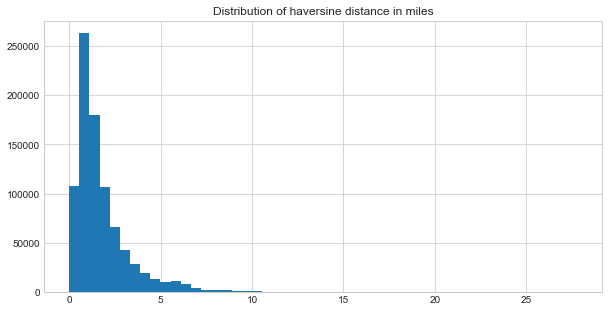

In [27]:
train_df.haversine.hist(bins=50, figsize=(10, 5))
plt.title('Distribution of haversine distance in miles')

It seems that most rides are short rides with a peak between 10-15 miles. This peak could be due to the fixed distance like airport trips.

In [28]:
train_df.haversine.describe()

count    874431.000000
mean          1.795571
std           1.630143
min           0.000000
25%           0.778119
50%           1.285477
75%           2.208660
max          27.743169
Name: haversine, dtype: float64

Let's see the number of rows with less than 0.05 miles and see if we can remove them.

In [29]:
len(train_df[train_df.haversine < 0.05])

9698

We have 9698 rows with less than 0.05 miles. Let's remove those rows.

In [30]:
# Let's drop rows where distance is less than 0.05 miles
prep_data = train_df[train_df.haversine >= 0.05]

In [31]:
prep_data.shape

(864733, 8)

Now let's plot to see the relation between distance and fare

### Plot distance Vs fare

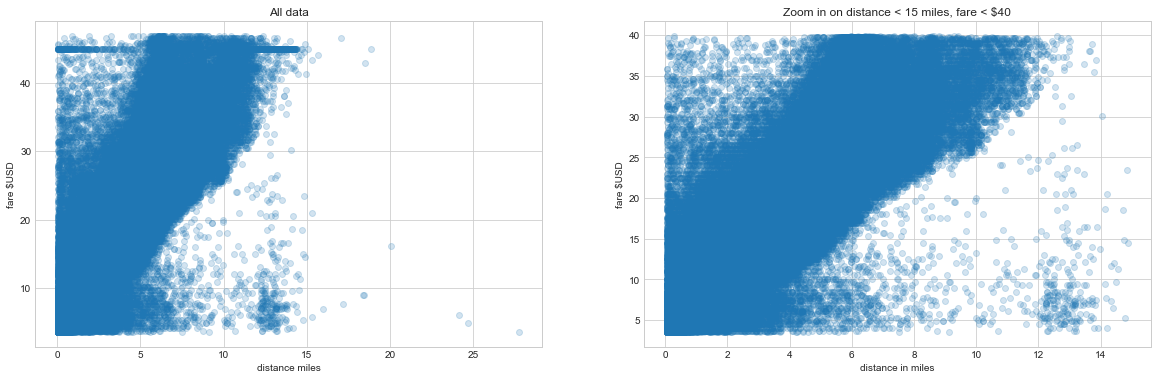

In [33]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].scatter(prep_data.haversine, prep_data.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance miles')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (prep_data.haversine < 15) & (prep_data.fare_amount < 40)
axs[1].scatter(prep_data[idx].haversine, prep_data[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance in miles')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 miles, fare < $40')

From this plot we see that:
* there are some distances (greater than 20) but will relatively low fare. Perhaps they are discounted trips?
* overall there also seems to be a positive correlation between distance and fare amount.
* the horizontal lines in the zoomed in plot shows the fixed fare amounts which might indicate the to/from airport trips.

## Distance to center

**Now let's add another column 'distance_to_center' which gives us the distance from center of new york city to the pick up locations.**

Reference: [click here](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration/)

In [35]:
# add new column to dataframe with distance to center of NYC
nyc_coordinates = (40.71, -74.00)
prep_data['distance_to_center'] = haversine_np(
    nyc_coordinates[1], nyc_coordinates[0], prep_data.pickup_longitude, prep_data.pickup_latitude)

In [36]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768


### Plot distance to center Vs fare

Plotting distance to center vs distance in miles Vs the fare amount should tell us something if the fare price varies with distance and may help us decide whether to remove the airport datapoints.

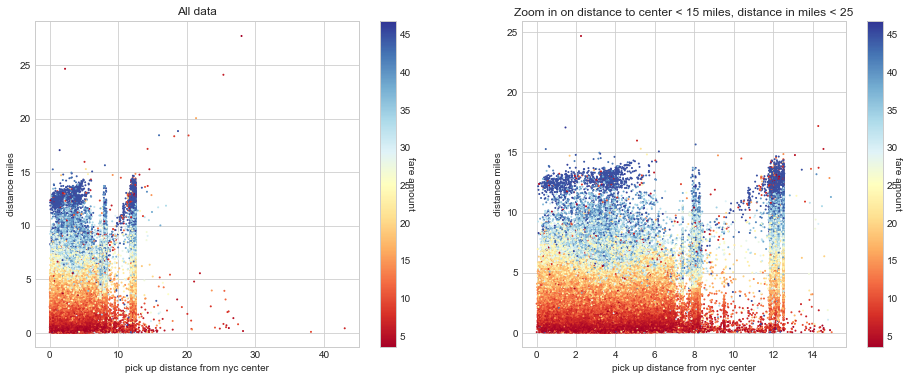

In [103]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sc = axs[0].scatter(prep_data.distance_to_center, prep_data.haversine, s=1, c=np.clip(
    prep_data.fare_amount, 0, 100), alpha=1.0, cmap='RdYlBu')
axs[0].set_ylabel('distance miles')
axs[0].set_xlabel('pick up distance from nyc center')
axs[0].set_title('All data')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.ax.set_ylabel('fare amount', rotation=270)

# zoom in on part of data
idx = (prep_data.distance_to_center < 15) & (prep_data.haversine < 25)
sc = axs[1].scatter(prep_data[idx].distance_to_center, prep_data[idx].haversine, s=1, c=np.clip(
    prep_data[idx].fare_amount, 0, 100), alpha=1.0, cmap='RdYlBu')
axs[1].set_ylabel('distance miles')
axs[1].set_xlabel('pick up distance from nyc center')
axs[1].set_title(
    'Zoom in on distance to center < 15 miles, distance in miles < 25')
cbar = fig.colorbar(sc, ax=axs[1])
cbar.ax.set_ylabel('fare amount', rotation=270)

From the above plots we see that, there are a lot of datapoints with fare amount between $40$-$50$ with distance between 10-14 miles of NYC center of distance of trip. Let's see if we can remove these datapoints as these are fixed fare amounts. 

## Calculate distance using Minkowski method

The [Minkowski Distance](https://en.wikipedia.org/wiki/Minkowski_distance) between two points is expressed as:
$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. You may also see these referred to as the l1 or l2 norm where the number indicates p in the equation.

These equations are only valid for actual distances in a cartesian coordinate system and here we only use them to find relative distances.
Reference: [click here](https://github.com/WillKoehrsen/taxi-fare/blob/master/A%20Walkthrough%20and%20a%20Challenge.ipynb)

In [37]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [38]:
prep_data['manhattan'] = minkowski_distance(prep_data['pickup_longitude'], prep_data['dropoff_longitude'],
                                            prep_data['pickup_latitude'], prep_data['dropoff_latitude'], 1)

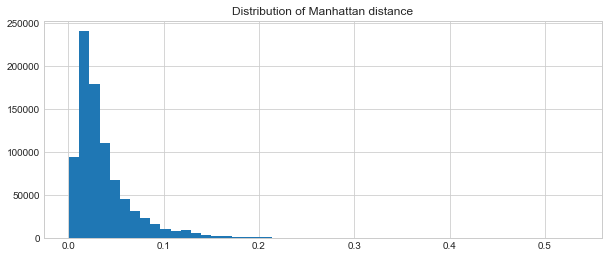

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
prep_data.manhattan.hist(bins=50, figsize=(10, 4))
plt.title("Distribution of Manhattan distance")
plt.show()

In [40]:
prep_data.manhattan.describe()

count    864733.000000
mean          0.038320
std           0.035465
min           0.000790
25%           0.016656
50%           0.027290
75%           0.046494
max           0.533127
Name: manhattan, dtype: float64

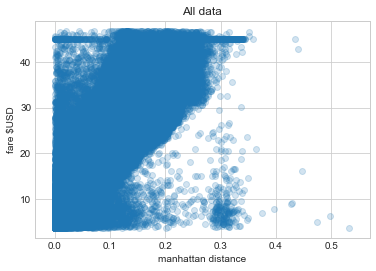

In [41]:
# scatter plot manhattan distance - fare
fig = plt.figure()
plt.scatter(prep_data.manhattan, prep_data.fare_amount, alpha=0.2)
plt.xlabel('manhattan distance')
plt.ylabel('fare $USD')
plt.title('All data')

In [42]:
prep_data['euclidean'] = minkowski_distance(prep_data['pickup_longitude'], prep_data['dropoff_longitude'],
                                            prep_data['pickup_latitude'], prep_data['dropoff_latitude'], 2)

In [43]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,euclidean
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,0.047917
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,0.033450
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,0.016513
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,0.019344
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,0.005872


In [44]:
prep_data.euclidean.describe()

count    864733.000000
mean          0.029877
std           0.028188
min           0.000733
25%           0.013031
50%           0.021195
75%           0.035561
max           0.529880
Name: euclidean, dtype: float64

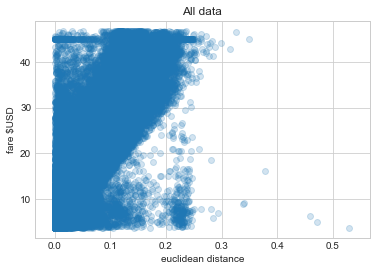

In [45]:
# scatter plot Euclidean distance - fare
fig = plt.figure()
plt.scatter(prep_data.euclidean, prep_data.fare_amount, alpha=0.2)
plt.xlabel('euclidean distance')
plt.ylabel('fare $USD')
plt.title('All data')

We see from the above scatter plots that all distances are linearly related to the fare amount.

## Calculate airport distances

We should also consider adding few more features which can be distances from popular New York airports:

    John F. Kennedy International Airport (JFK)
    Newark Liberty International Airport (EWR)
    LaGuardia Airport (LGA)
    
This may allow for better predictability of our model.

In [47]:
prep_data.shape

(864733, 11)

In [48]:
def add_distances_from_airport(dataset):
    # coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = haversine_np(
        jfk_coords[1], jfk_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_jfk_distance'] = haversine_np(
        jfk_coords[1], jfk_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)

    dataset['pickup_ewr_distance'] = haversine_np(
        ewr_coords[1], ewr_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_ewr_distance'] = haversine_np(
        ewr_coords[1], ewr_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)

    dataset['pickup_lga_distance'] = haversine_np(
        lga_coords[1], lga_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_lga_distance'] = haversine_np(
        lga_coords[1], lga_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)
    return dataset

In [49]:
prep_data = add_distances_from_airport(prep_data)

## Phase 3: Boolean feature for Airport trips

Let's also add a boolean feature for airport trips. If the distance to the airports is less than 1 mile, then the value is 1, and 0 otherwise. 

In [50]:
def airportTripColVal(row):
    out = 0
    if ((row['dropoff_jfk_distance'] < 1)
        | (row['dropoff_ewr_distance'] < 1)
        | (row['dropoff_lga_distance'] < 1)

        | (row['pickup_jfk_distance'] < 1)
        | (row['pickup_ewr_distance'] < 1)
            | (row['pickup_lga_distance'] < 1)):
        out = 1
    return out


def makeAirportTripCol(X):
    X['airport_trip'] = X.apply(airportTripColVal, axis=1)
    return X

In [51]:
prep_data = makeAirportTripCol(prep_data)

In [52]:
prep_data.airport_trip.value_counts()

0    829441
1     35292
Name: airport_trip, dtype: int64

In [53]:
prep_data.shape

(864733, 18)

In [54]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,euclidean,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance,airport_trip
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,0.047917,14.825809,13.873856,12.762623,10.208569,5.259472,6.472253,0
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,0.033450,13.253746,13.914821,9.290879,10.716195,7.306061,6.069034,0
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,0.016513,14.455372,14.506686,11.635426,12.589192,5.667262,5.113124,0
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,0.019344,13.070368,13.408644,9.058044,9.760714,7.624509,6.807695,0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,0.005872,13.821556,13.646517,9.570368,9.888708,7.022760,6.706591,0


## Timestamp features

**Now let's derive the timestamp related features using the pickup_datime feature.**

In [55]:
# Create new features (based on timestamp)
prep_data["hour"] = [
    t.hour for t in pd.DatetimeIndex(prep_data.pickup_datetime)]
prep_data["day"] = [t.dayofweek for t in pd.DatetimeIndex(
    prep_data.pickup_datetime)]
prep_data["month"] = [
    t.month for t in pd.DatetimeIndex(prep_data.pickup_datetime)]
prep_data['year'] = [
    t.year for t in pd.DatetimeIndex(prep_data.pickup_datetime)]

In [56]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,...,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance,airport_trip,hour,day,month,year
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,...,13.873856,12.762623,10.208569,5.259472,6.472253,0,23,5,8,2012
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,...,13.914821,9.290879,10.716195,7.306061,6.069034,0,20,3,12,2014
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,...,14.506686,11.635426,12.589192,5.667262,5.113124,0,20,3,3,2012
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,...,13.408644,9.058044,9.760714,7.624509,6.807695,0,11,4,12,2014
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,...,13.646517,9.570368,9.888708,7.022760,6.706591,0,13,5,5,2009


### Perform EDA on timestamp features

In [123]:
trips_year_fareamount = prep_data.groupby(['year'])['fare_amount'].mean(
).reset_index().rename(columns={'fare_amount': 'avg_fare_amount'})

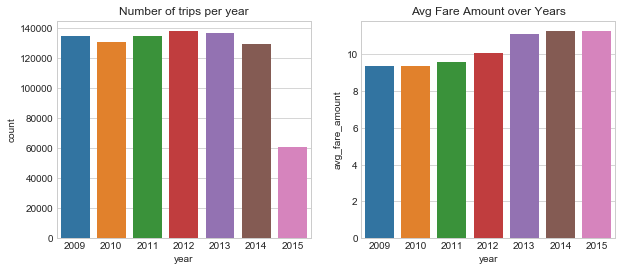

In [124]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='year', data=prep_data)
plt.title('Number of trips per year')

plt.subplot(1, 2, 2)
# Let's plot number of trips Vs avg. fare
sns.barplot(x='year', y='avg_fare_amount', data=trips_year_fareamount).set_title(
    "Avg Fare Amount over Years")

From the above plot we see that the avg. fare has increased over the years.

Text(0.5,1,'Number of trips per month')

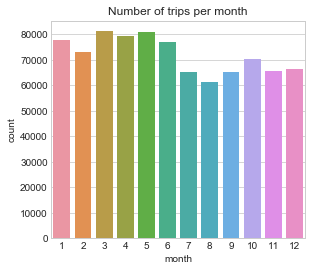

In [125]:
trips_month_fareamount = prep_data.groupby(['month'])['fare_amount'].mean(
).reset_index().rename(columns={'fare_amount': 'avg_fare_amount'})

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='month', data=prep_data)
plt.title('Number of trips per month')

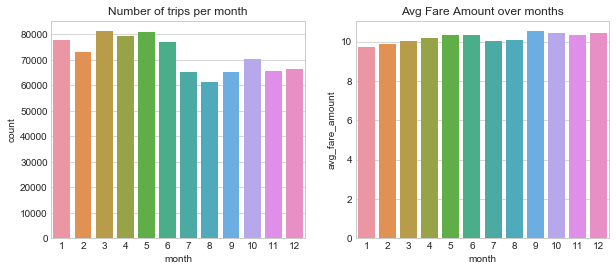

In [126]:
trips_month_fareamount = prep_data.groupby(['month'])['fare_amount'].mean(
).reset_index().rename(columns={'fare_amount': 'avg_fare_amount'})

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='month', data=prep_data)
plt.title('Number of trips per month')

plt.subplot(1, 2, 2)
# Let's plot number of trips Vs avg. fare
sns.barplot(x='month', y='avg_fare_amount', data=trips_month_fareamount).set_title(
    "Avg Fare Amount over months")

From the above plot we see that, avg. fares across months is fairly constant although the number of trips starts to decrease after June. There's one peak in November which could mean passengers taking taxis to airport/ other locations during Thanksgiving/ holiday season. 

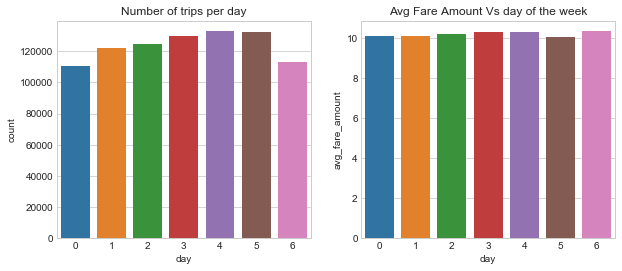

In [127]:
trips_day_fareamount = prep_data.groupby(['day'])['fare_amount'].mean(
).reset_index().rename(columns={'fare_amount': 'avg_fare_amount'})

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='day', data=prep_data)
plt.title('Number of trips per day')

plt.subplot(1, 2, 2)
# Let's plot number of trips Vs avg. fare
sns.barplot(x='day', y='avg_fare_amount', data=trips_day_fareamount).set_title(
    "Avg Fare Amount Vs day of the week")

With Monday=0 and Sunday=6, we see that the avg.fare amount across day of the week is farely constant except Saturday. Although the number of trips on Sunday and Monday is fairly less, the avg.fare amount is pretty high on these days.

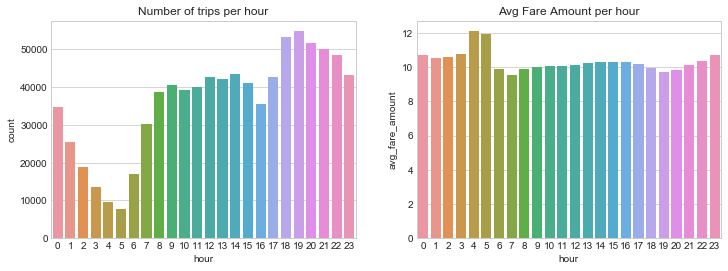

In [128]:
trips_hour_fareamount = prep_data.groupby(['hour'])['fare_amount'].mean(
).reset_index().rename(columns={'fare_amount': 'avg_fare_amount'})

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='hour', data=prep_data)
plt.title('Number of trips per hour')

plt.subplot(1, 2, 2)
# Let's plot number of trips Vs avg. fare
sns.barplot(x='hour', y='avg_fare_amount',
            data=trips_hour_fareamount).set_title("Avg Fare Amount per hour")

The above plot shows that the avg. fare amount during wee hours of the morning are higher, which might indicate the availibility of taxis is low at this time and hence the fare is relatively higher at this time. The number of trips are highest during late evening hours.

## Phase 3: Derive Night and Late-night features using timestamp derived features

Based on our above EDA for timestamp features, the fare amount is relatively high during late night and early morning hours. The number of trips and fare amount is also very high in the evening hours. Hence we will try to create new features based on this analysis. Reference: [click here](https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning)

In [57]:
def late_night(row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night(row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['day'] < 5):
        return 1
    else:
        return 0

In [58]:
prep_data['night'] = prep_data.apply(lambda x: night(x), axis=1)

In [59]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,...,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance,airport_trip,hour,day,month,year,night
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,...,12.762623,10.208569,5.259472,6.472253,0,23,5,8,2012,0
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,...,9.290879,10.716195,7.306061,6.069034,0,20,3,12,2014,1
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,...,11.635426,12.589192,5.667262,5.113124,0,20,3,3,2012,1
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,...,9.058044,9.760714,7.624509,6.807695,0,11,4,12,2014,0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,...,9.570368,9.888708,7.022760,6.706591,0,13,5,5,2009,0


In [60]:
prep_data['late_night'] = prep_data.apply(lambda x: late_night(x), axis=1)

In [61]:
prep_data.tail()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,...,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance,airport_trip,hour,day,month,year,night,late_night
999994,2009-11-23 08:07:00,-73.990497,40.756187,-73.979375,40.761232,1,5.30,0.678512,3.229965,0.016167,...,10.988482,6.338646,5.695616,0,8,0,11,2009,0,0
999995,2011-07-31 21:22:00,-73.987255,40.738552,-73.959585,40.774308,5,10.10,2.863847,2.082706,0.063426,...,12.317991,6.569255,4.555506,0,21,6,7,2011,0,1
999996,2013-12-18 09:33:39,-73.991140,40.749782,-73.952727,40.766120,2,25.50,2.305787,2.787714,0.054751,...,12.396012,6.487108,4.262332,0,9,2,12,2013,0,0
999998,2010-12-17 20:34:00,-73.863452,40.770093,-73.987478,40.756497,2,30.67,6.558587,8.267209,0.137622,...,10.465348,0.688663,6.179962,1,20,4,12,2010,1,1
999999,2009-04-22 16:42:24,-73.953012,40.776201,-73.958926,40.765815,1,8.10,0.781533,5.193796,0.016300,...,12.091922,4.207596,4.585363,0,16,2,4,2009,1,0


In [62]:
prep_data.shape

(864733, 24)

In [63]:
prep_data.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'fare_amount', 'haversine', 'distance_to_center', 'manhattan',
       'euclidean', 'pickup_jfk_distance', 'dropoff_jfk_distance',
       'pickup_ewr_distance', 'dropoff_ewr_distance', 'pickup_lga_distance',
       'dropoff_lga_distance', 'airport_trip', 'hour', 'day', 'month', 'year',
       'night', 'late_night'],
      dtype='object')

In [64]:
prep_data.night.value_counts()

0    689975
1    174758
Name: night, dtype: int64

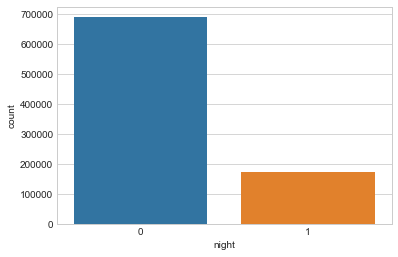

In [67]:
sns.countplot(x="night", data=prep_data)

In [68]:
prep_data.late_night.value_counts()

0    544305
1    320428
Name: late_night, dtype: int64

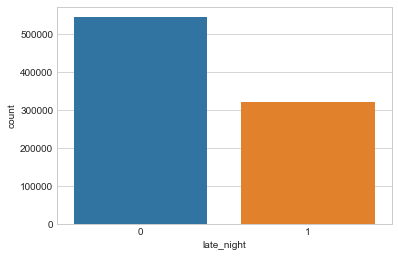

In [69]:
sns.countplot(x="late_night", data=prep_data)

## Phase 3 : Derive features based on clustering datapoints

NYC is divided into 5 boroughs namely Bronx, Brooklyn, Manhattan, Queens, and Staten Island. We thought clustering the datapoints would give us some intuition about how the location is related to fare amount. We have attempted to achieve this using KMeans clustering. K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. More info [here](https://www.datascience.com/blog/k-means-clustering).

In [71]:
from sklearn.cluster import KMeans

train_geo = prep_data[['pickup_longitude', 'pickup_latitude']]

model = KMeans(n_clusters=6)
model.fit(train_geo)
labels = model.predict(train_geo)

In [72]:
labels[0:5]

array([1, 0, 3, 4, 0])

In [73]:
prep_data['Pickup_cluster'] = labels

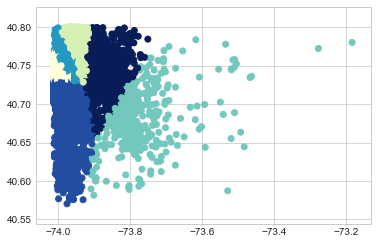

In [74]:
plt.scatter(prep_data['pickup_longitude'], prep_data['pickup_latitude'],
            c=prep_data['Pickup_cluster'], cmap="YlGnBu")

In [75]:
clusters = pd.get_dummies(
    prep_data['Pickup_cluster'], prefix='Pickup_Cluster', drop_first=False)

prep_data = pd.concat([prep_data, clusters], axis=1).drop(
    'Pickup_cluster', axis=1)

In [81]:
from sklearn.cluster import KMeans

train_geo = prep_data[['dropoff_longitude', 'dropoff_latitude']]

model = KMeans(n_clusters=6)
model.fit(train_geo)
labels = model.predict(train_geo)

In [82]:
prep_data['Dropoff_cluster'] = labels

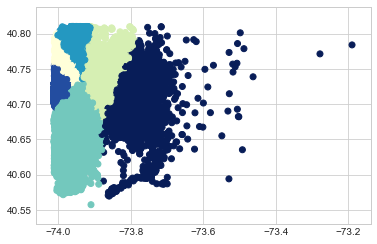

In [83]:
plt.scatter(prep_data['dropoff_longitude'], prep_data['dropoff_latitude'],
            c=prep_data['Dropoff_cluster'], cmap="YlGnBu")

In [85]:
clusters = pd.get_dummies(
    prep_data['Dropoff_cluster'], prefix='Dropoff_Cluster', drop_first=False)

prep_data = pd.concat([prep_data, clusters], axis=1).drop(
    'Dropoff_cluster', axis=1)

In [86]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,...,Pickup_Cluster_2,Pickup_Cluster_3,Pickup_Cluster_4,Pickup_Cluster_5,Dropoff_Cluster_0,Dropoff_Cluster_1,Dropoff_Cluster_2,Dropoff_Cluster_3,Dropoff_Cluster_4,Dropoff_Cluster_5
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,...,0,0,0,0,1,0,0,0,0,0
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,...,0,0,0,0,1,0,0,0,0,0
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,...,0,1,0,0,0,0,0,1,0,0
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,...,0,0,1,0,0,0,0,0,1,0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,...,0,0,0,0,1,0,0,0,0,0


## Find correlation after feature engineering

In [87]:
corr_matrix = prep_data.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount             1.000000
euclidean               0.882450
haversine               0.875900
manhattan               0.859176
airport_trip            0.622029
Pickup_Cluster_5        0.382859
pickup_longitude        0.370805
dropoff_longitude       0.369284
Dropoff_Cluster_1       0.346959
pickup_ewr_distance     0.309547
dropoff_ewr_distance    0.292884
Pickup_Cluster_2        0.250794
Dropoff_Cluster_2       0.248772
distance_to_center      0.237684
Dropoff_Cluster_5       0.203222
year                    0.113426
Pickup_Cluster_4        0.052785
month                   0.027612
late_night              0.026609
passenger_count         0.013316
day                     0.005883
hour                   -0.014984
night                  -0.017563
Pickup_Cluster_1       -0.053469
Dropoff_Cluster_3      -0.062358
dropoff_lga_distance   -0.062610
Dropoff_Cluster_4      -0.073237
Pickup_Cluster_0       -0.085270
Pickup_Cluster_3       -0.088008
pickup_latitude        -0.114952
pickup_lga

Text(0.5,1,'Heatmap of Correlation Matrix')

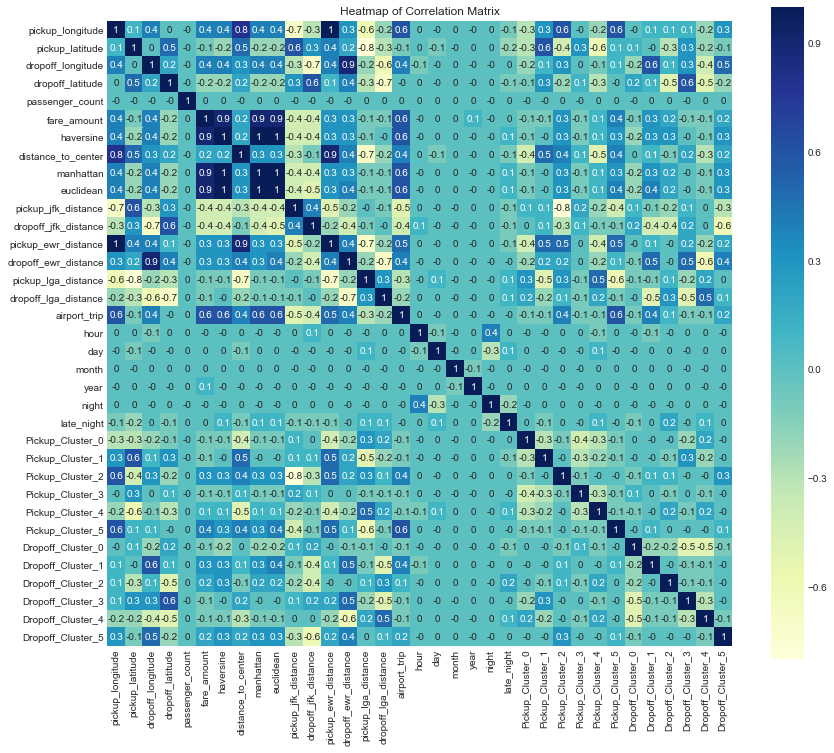

In [88]:
plt.figure(figsize=(14, 12))
sns.heatmap(np.round(corr_matrix, 1), square=True, annot=True, cmap="YlGnBu",
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

In [89]:
prep_data.shape

(864733, 36)

## Wrap feature engineering steps in a pipeline 

Now let us add all of the steps of feature engineering into a pipeline. 

The below class is used for deriving new features out of our existing numerical/ timestamp features. We are deriving the timestamp related features (hour, day, month and year), distance features using Haversine formula and Minkowski formula, airport distances, boolean features for airport trips, night and late_night features and features from clustering data points.

In [90]:
prepared_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [91]:
# derive the timestamp features using pickup_datetime feature
def extract_date(X_val, dt_ix):
    h = [t.hour for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    d = [t.dayofweek for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    m = [t.month for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    y = [t.year for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    return h, d, m, y

# boolean feature for late_night trips


def late_night(row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0

# boolean feature for night trips


def night(row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['day'] < 5):
        return 1
    else:
        return 0

# Calculate distance in miles between pickup and dropoff using Haversine formula


def haversine_distance(X_val, lon1_idx, lat1_idx, lon2_idx, lat2_idx, r):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    lon1 = X_val[:, lon1_idx].astype(float)
    lat1 = X_val[:, lat1_idx].astype(float)
    lon2 = X_val[:, lon2_idx].astype(float)
    lat2 = X_val[:, lat2_idx].astype(float)

    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to miles
    miles = r * c

    return miles

# Calculate airport distances between pickup and dropoff using Haversine formula


def calculate_airport_distance(X_val, lon1, lat1, lon2_idx, lat2_idx, r):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    lon2 = X_val[:, lon2_idx].astype(float)
    lat2 = X_val[:, lat2_idx].astype(float)

    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to miles
    miles = r * c

    return miles

# Calculate Manhattan and Euclidean distances using Minkowski formula


def minkowski_distance(X_val, x1, x2, y1, y2, p):
    """
    Function to calculate the relative distance based on 
    Euclidean and Manhattan formula.

    """
    return ((abs(X_val[:, x2] - X_val[:, x1]) ** p) + (abs(X_val[:, y2] - X_val[:, y1])) ** p) ** (1 / p)

# Cluster datapoints based on pickup and dropoff locations


def clustering_geolocations(X_val, lon_ix, lat_ix):

    train_geo = X_val[:, lon_ix:lat_ix+1].astype(float)
    model = KMeans(n_clusters=6)
    model.fit(train_geo)
    labels = model.predict(train_geo)
    return labels

# Boolean feature for airport trips


def airportTripColVal(row):
    out = 0
    if ((row['dropoff_jfk_distance'] < 1)
        | (row['dropoff_ewr_distance'] < 1)
        | (row['dropoff_lga_distance'] < 1)

        | (row['pickup_jfk_distance'] < 1)
        | (row['pickup_ewr_distance'] < 1)
            | (row['pickup_lga_distance'] < 1)):
        out = 1
    return out


def makeAirportTripCol(X):
    X['airport_trip'] = X.apply(airportTripColVal, axis=1)
    return X

### Class to derive new features

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

# column index
datetime_ix, lon1_ix, lat1_ix, lon2_ix, lat2_ix = 0, 1, 2, 3, 4

# Radius of the earth in miles
R = 3959
nyc_coordinates = (40.71, -74.00)
jfk_coords = (40.639722, -73.778889)
ewr_coords = (40.6925, -74.168611)
lga_coords = (40.77725, -73.872611)

col = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare_amount', 'hour', 'day',
       'month', 'year', 'haversine', 'distance_to_center',
       'pickup_jfk_distance', 'dropoff_jfk_distance',
       'pickup_ewr_distance', 'dropoff_ewr_distance',
       'pickup_lga_distance', 'dropoff_lga_distance',
       'pickup_cluster', 'dropoff_cluster']


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, col):  # no *args or **kargs
        """

        A class to derive new features from numerical features.

        """
        self.col = col

    def fit(self, X, y=None):

        return self  # nothing else to do

    def transform(self, X, y=None):

        hour, day, month, year = extract_date(X, datetime_ix)
        haversine = haversine_distance(
            X, lon1_ix, lat1_ix, lon2_ix, lat2_ix, R)

        #manhattan = minkowski_distance(X, lon1_ix, lon2_ix, lat1_ix, lat2_ix, 1)
        #euclidean = minkowski_distance(X, lon1_ix, lon2_ix, lat1_ix, lat2_ix, 2)

        distance_to_center = calculate_airport_distance(
            X, nyc_coordinates[1], nyc_coordinates[0], lon1_ix, lat1_ix, R)

        pickup_jfk_distance = calculate_airport_distance(
            X, jfk_coords[1], jfk_coords[0], lon1_ix, lat1_ix, R)
        dropoff_jfk_distance = calculate_airport_distance(
            X, jfk_coords[1], jfk_coords[0], lon2_ix, lat2_ix, R)

        pickup_ewr_distance = calculate_airport_distance(
            X, ewr_coords[1], ewr_coords[0], lon1_ix, lat1_ix, R)
        dropoff_ewr_distance = calculate_airport_distance(
            X, ewr_coords[1], ewr_coords[0], lon2_ix, lat2_ix, R)

        pickup_lga_distance = calculate_airport_distance(
            X, lga_coords[1], lga_coords[0], lon1_ix, lat1_ix, R)
        dropoff_lga_distance = calculate_airport_distance(
            X, lga_coords[1], lga_coords[0], lon2_ix, lat2_ix, R)

        pickup_labels = clustering_geolocations(X, lon1_ix, lat1_ix)
        pickup_cluster = pickup_labels

        dropoff_labels = clustering_geolocations(X, lon2_ix, lat2_ix)
        dropoff_cluster = dropoff_labels

        X = np.delete(X, 0, axis=1)

        feat_arr = np.c_[X, hour, day, month, year, haversine, distance_to_center,
                         pickup_jfk_distance, dropoff_jfk_distance, pickup_ewr_distance, dropoff_ewr_distance,
                         pickup_lga_distance, dropoff_lga_distance, pickup_cluster, dropoff_cluster]  # manhattan, euclidean, excluded

        feat_df = pd.DataFrame(data=feat_arr, columns=self.col)

        cluster_pickup = pd.get_dummies(
            feat_df['pickup_cluster'], prefix='pickup_cluster', drop_first=False)
        cluster_dropoff = pd.get_dummies(
            feat_df['dropoff_cluster'], prefix='dropoff_cluster', drop_first=False)

        feat_df = pd.concat([feat_df, cluster_pickup], axis=1).drop(
            'pickup_cluster', axis=1)
        feat_df = pd.concat([feat_df, cluster_dropoff], axis=1).drop(
            'dropoff_cluster', axis=1)

        feat_df = makeAirportTripCol(feat_df)

        feat_df = feat_df.infer_objects()

        return feat_df

In [93]:
num_attribs = ['pickup_datetime',
               'pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'passenger_count',
               'fare_amount']

feature_eng_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('attribs_adder', CombinedAttributesAdder(col))
])

sampletrain_prepared = feature_eng_pipeline.fit_transform(prepared_data)

In [94]:
sampletrain_prepared.shape

(874431, 31)

In [95]:
sampletrain_prepared.dtypes

pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
passenger_count           int64
fare_amount             float64
hour                      int64
day                       int64
month                     int64
year                      int64
haversine               float64
distance_to_center      float64
pickup_jfk_distance     float64
dropoff_jfk_distance    float64
pickup_ewr_distance     float64
dropoff_ewr_distance    float64
pickup_lga_distance     float64
dropoff_lga_distance    float64
pickup_cluster_0          uint8
pickup_cluster_1          uint8
pickup_cluster_2          uint8
pickup_cluster_3          uint8
pickup_cluster_4          uint8
pickup_cluster_5          uint8
dropoff_cluster_0         uint8
dropoff_cluster_1         uint8
dropoff_cluster_2         uint8
dropoff_cluster_3         uint8
dropoff_cluster_4         uint8
dropoff_cluster_5         uint8
airport_trip              int64
dtype: o

### Phase3: Class for deriving night and late_night features from timestamp derived features

In [96]:
class CombinedAttributesAdder2(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        A class to derive night features from timestamp
        derived features.

        """

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        X['night'] = X.apply(lambda x: night(x), axis=1)
        X['late_night'] = X.apply(lambda x: late_night(x), axis=1)
        return X

### Class for data cleanup after feature engineering

In [98]:
class DataCleaner2(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        A class to filter distances less than 0.05 miles.

        """

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        X = X[X.haversine >= 0.05]
        return X

In [99]:
filter_distance_pipeline = Pipeline([
    ('data_cleaner', DataCleaner2()),
    ('night_features', CombinedAttributesAdder2())
])

train_prep = filter_distance_pipeline.fit_transform(sampletrain_prepared)

In [100]:
train_prep.shape

(864733, 33)

In [101]:
train_prep.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,year,...,pickup_cluster_5,dropoff_cluster_0,dropoff_cluster_1,dropoff_cluster_2,dropoff_cluster_3,dropoff_cluster_4,dropoff_cluster_5,airport_trip,night,late_night
0,-73.969091,40.798644,-73.993477,40.757396,1,12.5,23,5,8,2012,...,0,1,0,0,0,0,0,0,0,1
1,-73.999625,40.733399,-73.987364,40.764521,1,14.5,20,3,12,2014,...,0,1,0,0,0,0,0,0,1,1
2,-73.980710,40.782418,-73.968085,40.793062,1,5.3,20,3,3,2012,...,0,0,0,0,0,1,0,0,1,1
3,-74.001232,40.725463,-73.994935,40.743753,1,10.0,11,4,12,2014,...,1,0,0,0,1,0,0,0,0,0
4,-74.000990,40.747675,-73.995413,40.749512,3,4.5,13,5,5,2009,...,0,1,0,0,0,0,0,0,0,0


In [102]:
train_prep.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'fare_amount', 'hour', 'day',
       'month', 'year', 'haversine', 'distance_to_center',
       'pickup_jfk_distance', 'dropoff_jfk_distance', 'pickup_ewr_distance',
       'dropoff_ewr_distance', 'pickup_lga_distance', 'dropoff_lga_distance',
       'pickup_cluster_0', 'pickup_cluster_1', 'pickup_cluster_2',
       'pickup_cluster_3', 'pickup_cluster_4', 'pickup_cluster_5',
       'dropoff_cluster_0', 'dropoff_cluster_1', 'dropoff_cluster_2',
       'dropoff_cluster_3', 'dropoff_cluster_4', 'dropoff_cluster_5',
       'airport_trip', 'night', 'late_night'],
      dtype='object')

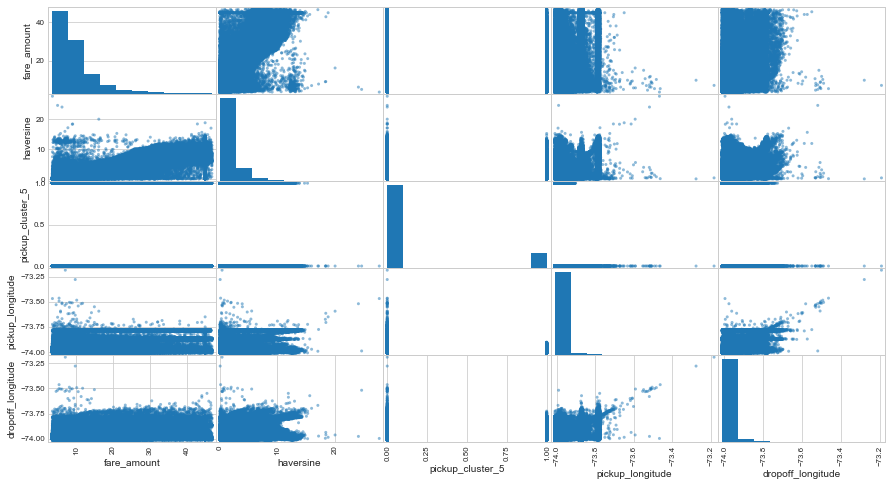

In [103]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with fare_amount
attributes = ["fare_amount", "haversine", "pickup_cluster_5",
              "pickup_longitude", "dropoff_longitude"]
scatter_matrix(train_prep[attributes], figsize=(15, 8))

# Feature Selection

In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for four reasons:

        simplification of models to make them easier to interpret by researchers/users,
        shorter training times,
        to avoid the curse of dimensionality,
        enhanced generalization by reducing overfitting (formally, reduction of variance)
        
Reference: [click here](https://en.wikipedia.org/wiki/Feature_selection)

Feature selection is different from dimensionality reduction. Both methods seek to reduce the number of attributes in the dataset, but a dimensionality reduction method do so by creating new combinations of attributes, where as feature selection methods include and exclude attributes present in the data without changing them. [reference](https://machinelearningmastery.com/an-introduction-to-feature-selection/)

## Using SelectKBest technique

Statistical tests can be used to select those features that have the strongest relationship with the output variable.
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features. SelectKBest for linear regression uses a univariate linear regression tests call f_regression. f_regression is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression).

In [104]:
train_prep.shape

(864733, 33)

In [105]:
train_prep.dtypes

pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
passenger_count           int64
fare_amount             float64
hour                      int64
day                       int64
month                     int64
year                      int64
haversine               float64
distance_to_center      float64
pickup_jfk_distance     float64
dropoff_jfk_distance    float64
pickup_ewr_distance     float64
dropoff_ewr_distance    float64
pickup_lga_distance     float64
dropoff_lga_distance    float64
pickup_cluster_0          uint8
pickup_cluster_1          uint8
pickup_cluster_2          uint8
pickup_cluster_3          uint8
pickup_cluster_4          uint8
pickup_cluster_5          uint8
dropoff_cluster_0         uint8
dropoff_cluster_1         uint8
dropoff_cluster_2         uint8
dropoff_cluster_3         uint8
dropoff_cluster_4         uint8
dropoff_cluster_5         uint8
airport_trip              int64
night   

In [106]:
from sklearn.feature_selection import SelectKBest, f_regression
y = train_prep['fare_amount']
X = train_prep.drop(['fare_amount'], axis=1)

In [107]:
print(X.shape)
print(y.shape)

(864733, 32)
(864733,)


In [108]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,haversine,...,pickup_cluster_5,dropoff_cluster_0,dropoff_cluster_1,dropoff_cluster_2,dropoff_cluster_3,dropoff_cluster_4,dropoff_cluster_5,airport_trip,night,late_night
0,-73.969091,40.798644,-73.993477,40.757396,1,23,5,8,2012,3.122720,...,0,1,0,0,0,0,0,0,0,1
1,-73.999625,40.733399,-73.987364,40.764521,1,20,3,12,2014,2.244191,...,0,1,0,0,0,0,0,0,1,1
2,-73.980710,40.782418,-73.968085,40.793062,1,20,3,3,2012,0.988520,...,0,0,0,0,0,1,0,0,1,1
3,-74.001232,40.725463,-73.994935,40.743753,1,11,4,12,2014,1.306093,...,1,0,0,0,1,0,0,0,0,0
4,-74.000990,40.747675,-73.995413,40.749512,3,13,5,5,2009,0.318340,...,0,1,0,0,0,0,0,0,0,0


In [163]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [164]:
from sklearn.feature_selection import SelectKBest, f_regression
# k is an arbitrary number of features
# we will use our pipeline below to select based on p values
Kbest = SelectKBest(f_regression, k=5)
X_train_sel = Kbest.fit_transform(X_train, y_train)

In [165]:
featureScores = Kbest.scores_
pd.DataFrame({'F statistic': Kbest.scores_,
              'p value': Kbest.pvalues_}).sort_values(by='p value')

,F statistic,p value
0,1.094752e+05,0.000000e+00
29,4.376678e+05,0.000000e+00
28,2.952530e+04,0.000000e+00
27,3.730373e+03,0.000000e+00
26,4.563062e+04,0.000000e+00
25,2.709799e+03,0.000000e+00
24,9.499243e+04,0.000000e+00
23,1.485908e+04,0.000000e+00
22,1.976852e+03,0.000000e+00
21,1.947126e+03,0.000000e+00


In [109]:
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features


def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns

    return feat_scores

In [110]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

df = pd.DataFrame(X_train, columns=X_train.columns).copy()
df["fare_amount"] = y_train

per_feat = select_kbest_reg(df, 'fare_amount', k=5)
per_feat_sorted = per_feat.sort_values(
    ["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)

# print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

         F Score        P Value  Support             Attribute
9   2.273438e+06   0.000000e+00     True             haversine
29  4.376678e+05   0.000000e+00     True          airport_trip
12  1.376179e+05   0.000000e+00     True  dropoff_jfk_distance
21  1.198067e+05   0.000000e+00     True      pickup_cluster_4
0   1.094752e+05   0.000000e+00     True      pickup_longitude
2   1.091852e+05   0.000000e+00    False     dropoff_longitude
11  1.032478e+05   0.000000e+00    False   pickup_jfk_distance
25  9.498787e+04   0.000000e+00    False     dropoff_cluster_2
13  7.263225e+04   0.000000e+00    False   pickup_ewr_distance
14  6.466670e+04   0.000000e+00    False  dropoff_ewr_distance
28  4.563124e+04   0.000000e+00    False     dropoff_cluster_5
18  4.543888e+04   0.000000e+00    False      pickup_cluster_1
10  4.089455e+04   0.000000e+00    False    distance_to_center
24  2.952530e+04   0.000000e+00    False     dropoff_cluste

## Plot input variable importance

In [111]:
# Order of appearance in dataframe
feature_importances = per_feat[["F Score", "Attribute"]]
# print(feature_importances)
# Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]]
feature_importances_sorted

,F Score,Attribute
9,2.273438e+06,haversine
29,4.376678e+05,airport_trip
12,1.376179e+05,dropoff_jfk_distance
21,1.198067e+05,pickup_cluster_4
0,1.094752e+05,pickup_longitude
2,1.091852e+05,dropoff_longitude
11,1.032478e+05,pickup_jfk_distance
25,9.498787e+04,dropoff_cluster_2
13,7.263225e+04,pickup_ewr_distance
14,6.466670e+04,dropoff_ewr_distance


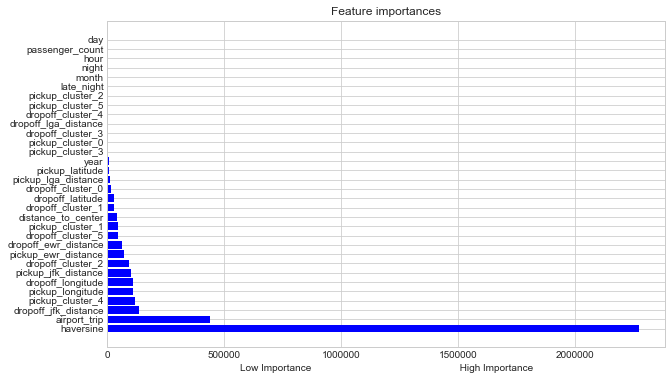

In [112]:
# Plot the feature importance
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.figure(figsize=[10, 6])
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

#plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel(
    'Low Importance                                                      High Importance')
plt.grid(True)
plt.show()

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances
# We did so in the cell above with the feature importance scores stored in Kbest.scores_


def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(
            self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features

    def transform(self, X):
        return X[:, self.feature_indices_]

In [114]:
# flatten the feature score values
featureScores = feature_importances[["F Score"]].values.flatten()
print(featureScores)

[1.09475195e+05 9.15290089e+03 1.09185167e+05 2.84847371e+04
 1.13656661e+02 1.67323313e+02 3.26241071e+01 5.01237778e+02
 8.96719682e+03 2.27343796e+06 4.08945500e+04 1.03247767e+05
 1.37617890e+05 7.26322460e+04 6.46666991e+04 1.21028645e+04
 2.74361317e+03 5.11951667e+03 4.54388815e+04 2.02121437e+03
 5.36784074e+03 1.19806694e+05 2.09819937e+03 1.48584696e+04
 2.95253002e+04 9.49878696e+04 3.73252072e+03 2.70842435e+03
 4.56312430e+04 4.37667814e+05 2.30925316e+02 5.10549587e+02]


In [115]:
# Feature selection in a pipeline
scaler_pipeline = Pipeline([
    ('night_features', CombinedAttributesAdder2()),
    ('data_cleaner', DataCleaner2()),
    ('std_scaler', StandardScaler()),
    ('feature selection', TopFeatureSelector(featureScores, 15))

])

trainprep = scaler_pipeline.fit_transform(sampletrain_prepared)

In [116]:
trainprep.shape

(864733, 15)

## Phase 3 : Using Sequential Backward Selection

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k<d. The motivation behind feature selection algorithms is to automatically select a subset of features that are most relevant to the problem, to improve computational efficiency or reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don't support regularization.

A classic sequential feature selection algorithm is Sequential Backward Selection (SBS), which aims to reduce the dimensionality of the initial feature subspace with a minimum decay in performance of the classifier to improve upon computational efficiency. In certain cases, SBS can even improve the predictive power of the model if a model suffers from overfitting.

The idea behind the SBS algorithm is quite simple: SBS sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features.  

In [174]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                            random_state=self.random_state)

        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        dim = X_train.shape[1]
        self.indices_ = list(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, list(p))
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [175]:
from sklearn.metrics import explained_variance_score
lr = LinearRegression()
sbs = SBS(lr, 1, scoring=explained_variance_score)
sbs.fit(X_train, y_train)

(518839, 32) (518839,)
(172947, 32) (172947,)


Text(0.5,0,'number of features')

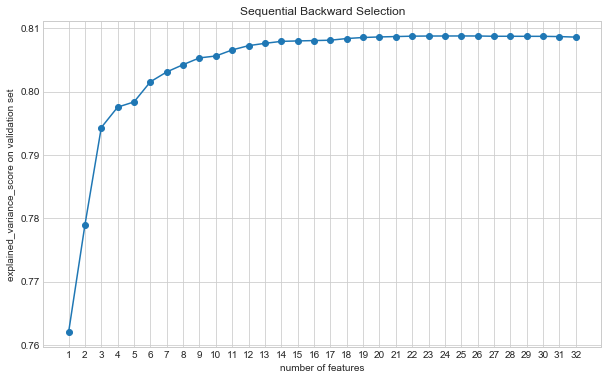

In [176]:
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

# plot places the points on the graph using the number of features (no need to sort!)
plt.figure(figsize=(10, 6))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.xticks(k_feat)
#plt.ylim([0.0, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('explained_variance_score on validation set')
plt.xlabel(r'number of features')

In [177]:
class SBSFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, subsets, k):
        self.subsets = subsets
        self.k = k

    def fit(self, X, y=None):
        # pull the k-th subset from the end
        self.feature_indices_ = sbs.subsets_[len(self.subsets)-self.k]
        return self
    # select the columns of data matrix of the selected input features

    def transform(self, X):
        return X[:, self.feature_indices_]

In [178]:
# This is just for reference
pipe = Pipeline([
    ("std_scaler", StandardScaler()),
    ('feature_selection', SBSFeatureSelector(sbs.subsets_, k=24)),
    ('linreg', LinearRegression())
])

Beyond 15 features, there's not much additional benefit in terms of explained variance.

# Model Evaluation

## Build Pipelines

Applied Machine learning consists of standard workflows which can be automated using Pipelines. Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated. Python's scikit-learn provides a Pipeline utility to help automate machine learning workflows. The goal is to ensure that all of the steps in the pipeline are constrained to the data available for the evaluation, such as the training dataset or each fold of the cross validation procedure. [Reference](https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/)

As such, we have designed two pipelines for our problem. First one is the **dataprep_pipeline** which cleans the data, removes outliers, creates features and does additional data cleanup. The second pipeline is the **predictor_pipeline** which standardizes the data using StandardScaler, does feature selection, and runs the predictor on the tranformed data. 

In [179]:
num_attribs = ['pickup_datetime',
               'pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'passenger_count',
               'fare_amount',
               ]

features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'fare_amount', 'hour', 'day',
            'month', 'year', 'haversine', 'distance_to_center',
            'pickup_jfk_distance', 'dropoff_jfk_distance',
            'pickup_ewr_distance', 'dropoff_ewr_distance',
            'pickup_lga_distance', 'dropoff_lga_distance',
            'pickup_cluster', 'dropoff_cluster']

dataprep_pipeline = Pipeline([
    ('data_cleaner', DataCleaner(low=0.02, high=0.98)),
    ('selector', DataFrameSelector(num_attribs)),
    ('attribs_adder', CombinedAttributesAdder(features)),
    ('night_features', CombinedAttributesAdder2()),
    ('data_cleaner2', DataCleaner2()),
])

In [180]:
predictor_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('feature selection', TopFeatureSelector(featureScores, 15)),
    ('predictor', XGBRegressor(n_estimators=1000, learning_rate=0.2,
                               max_depth=3, n_jobs=-1))  # Best predictor from Phase 2
])

In [181]:
# sampletrain consists of 1 million rows of raw data
prepared_data = dataprep_pipeline.fit_transform(sampletrain)

In [182]:
prepared_data.shape

(864733, 33)

In [183]:
prepared_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,year,...,pickup_cluster_5,dropoff_cluster_0,dropoff_cluster_1,dropoff_cluster_2,dropoff_cluster_3,dropoff_cluster_4,dropoff_cluster_5,airport_trip,night,late_night
0,-73.969091,40.798644,-73.993477,40.757396,1,12.5,23,5,8,2012,...,0,1,0,0,0,0,0,0,0,1
1,-73.999625,40.733399,-73.987364,40.764521,1,14.5,20,3,12,2014,...,0,1,0,0,0,0,0,0,1,1
2,-73.980710,40.782418,-73.968085,40.793062,1,5.3,20,3,3,2012,...,0,0,0,0,1,0,0,0,1,1
3,-74.001232,40.725463,-73.994935,40.743753,1,10.0,11,4,12,2014,...,0,0,1,0,0,0,0,0,0,0
4,-74.000990,40.747675,-73.995413,40.749512,3,4.5,13,5,5,2009,...,0,1,0,0,0,0,0,0,0,0


## Split the training data

Lets split sample training dataset into train and validation sets for experimentation purpose. We will train our models on train part and validate against val part.

In [184]:
y = prepared_data['fare_amount']
X = prepared_data.drop(['fare_amount'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [185]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((691786, 32), (691786,), (172947, 32), (172947,))

## Baseline model XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)

Let's benchmark our results with Best Regression Model from Phase 2. 

In [186]:
from time import time

start = time()
predictor_pipeline.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
xgb_scores = cross_val_score(
    predictor_pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
xgb_score_train = np.sqrt(-xgb_scores.mean())
train_time = np.round(time()-start, 4)

# Time and score test predictions
start = time()
X_val_prediction = predictor_pipeline.predict(X_val)
xgb_score_mse = mean_squared_error(y_val, X_val_prediction)
xgb_score_test = np.sqrt(xgb_score_mse)
test_time = np.round(time()-start, 4)

In [187]:
xgb_scores

array([-7.67255251, -7.62491271, -7.78874668, -7.68305087, -7.58679819,
       -7.67124179, -7.73173519, -7.68692026, -7.75101323, -7.63044156,
       -7.65933074, -7.65159712, -7.65095092, -7.57092184, -7.72922608,
       -7.80130635, -7.68385295, -7.64291694, -7.79328968, -7.61237293,
       -7.60944337, -7.70766313, -7.55460948, -7.64397939, -7.62318311,
       -7.60494341, -7.75190131, -7.71033716, -7.62593021, -7.6029199 ])

In [188]:
results.loc[0] = ["Phase 2 Baseline", xgb_score_train, xgb_score_test,
                  "---", "---", train_time, test_time, "XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"]
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 2 Baseline,2.769224,2.75439,---,---,3636.1605,0.6094,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"


### Phase 3: Take log of Target column

(array([322128., 209851.,  76584.,  35272.,  15704.,  10760.,   8992.,
          5795.,   3272.,   3428.]),
 array([ 3.5  ,  7.833, 12.166, 16.499, 20.832, 25.165, 29.498, 33.831,
        38.164, 42.497, 46.83 ]),
 <a list of 10 Patch objects>)

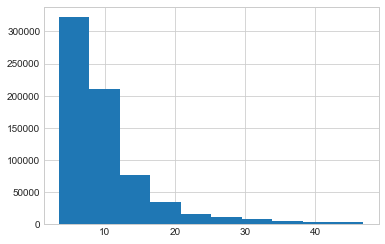

In [189]:
plt.hist(y_train)

(array([ 68187.,  94086., 142628., 135361., 104105.,  69339.,  34163.,
         18751.,  16111.,   9055.]),
 array([1.25276297, 1.51213907, 1.77151518, 2.03089128, 2.29026739,
        2.5496435 , 2.8090196 , 3.06839571, 3.32777181, 3.58714792,
        3.84652402]),
 <a list of 10 Patch objects>)

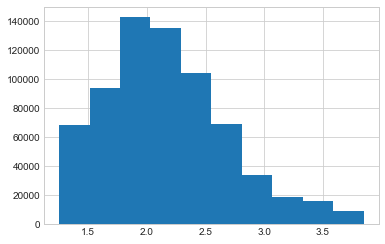

In [190]:
plt.hist(np.log(y_train))

In [191]:
from time import time

start = time()
predictor_pipeline.fit(X_train, np.log(y_train))

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
xgb_scores_ylog = cross_val_score(predictor_pipeline, X_train, np.log(
    y_train), scoring="neg_mean_squared_error", cv=cv)
xgb_score_train_ylog = np.sqrt(-xgb_scores_ylog.mean())
train_time = np.round(time()-start, 4)

# Time and score test predictions
start = time()
X_val_prediction = predictor_pipeline.predict(X_val)
xgb_score_mse_ylog = mean_squared_error(y_val, np.exp(X_val_prediction))
xgb_score_test_ylog = np.sqrt(xgb_score_mse_ylog)
test_time = np.round(time()-start, 4)

In [192]:
results.loc[len(results)] = ["Phase 2 Baseline + log(Target)", xgb_score_train_ylog, xgb_score_test_ylog,
                             "---", "---", train_time, test_time, "XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"]
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 2 Baseline,2.769224,2.75439,---,---,3636.1605,0.6094,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"
1,Phase 2 Baseline + log(Target),0.227463,2.77236,---,---,2741.4326,0.6407,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"


## Phase3: Build a Deep learning model

We will build a dense, fully-connected deep learning model using the Sequential API. The Sequential framework allows us to build a model by adding one layer at a time. We will make use of Keras, an open source neural network library written in Python to build a deep neural network. Keras is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, or Theano.  

Using the **Sequential API**, we can add one layer at a time. For each layer, we need to specify:

    The number of neurons
    The activation function

The first layer must also have an input_shape or an input_dim which in this case is the number of top features in our data. The final layer has no activation function because it provides the final estimate.

**Dense Layers**

All the layers are dense, indicating that the inputs are connected to every neuron in the layer. This means that each neuron has one weight for every input. A dense network is the only way to handle stuctured data (at the moment).

**Dropout**

Dropout is an effective technique for regularizing a neural network (preventing overfitting). It randomly sets the weights of a fraction of the neurons to 0 for each training batch. The reason this works is because it builds resiliency into the network. We'll use a dropout layer after each Dense layers.


**Compile Model**

To compile a model, we need two parts:

    An optimizer: the method used for adjusting the weights on each batch
    A loss: the measure of the model's error that is minimized by the optimization procedure

To monitor performance, we'll add in our custom scoring metric.

Keras does not offer the root mean squared error as one of the scoring functions. Instead, we have written our own custom scoring function to calculate the negative mean squared error. 

In [193]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-validation and model selection
from keras import losses
from keras import backend as K

# Custom scoring function for Root mean squared error calculation


def neg_mean_squared_error(y_true, y_pred):
    return (- K.mean(K.square(y_pred - y_true), axis=-1))


def create_model(dropout=0.1):

    model = Sequential()
    model.add(Dense(64, input_dim=15, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    #model.compile(loss='mse', optimizer='adagrad', metrics=['mae'])
    model.compile(loss='mse', optimizer='adam',
                  metrics=[neg_mean_squared_error])
    model.summary()
    return model

## Hyperparameter Tuning using RandomSearch, GridSearchCV and Statistical significance tests

Now, let's create a wrapper method, which will : <p>
    - execute full pipeline with predictor
    - perform RandomizedSearch for selected features
    - perform GridSearch for selected set of parameters 
    - report best set of parameters
    - calculate RMSE
    - perform t-test with best estimator set
    - populate results table

### Perform Random Search

We can use Sequential Keras models as part of our Scikit-Learn workflow via the wrappers found at keras.wrappers.scikit_learn.py. We will make use of keras.wrappers.scikit_learn.KerasRegressor(build_fn=None, \*\*sk_params), which implements the Scikit-Learn regressor interface. More info [here](https://keras.io/scikit-learn-api/)

In [194]:
# A Function to execute the random search using RandomizedSearchCV and record the results.
def ConductRandomizedSearch(X_train, y_train, X_val, y_val, i=0, prefix=''):

    # Create a list of regressors for our random search experiment

    # polynomial = Pipeline([
    #    ("PolynomialFeatures", PolynomialFeatures(degree=2)),
    #    ("Ridge", Ridge()),
    #    ])

    keras = KerasRegressor(build_fn=create_model,
                           verbose=1, batch_size=10000, epochs=50)

    regressors = [
        #('RandomForestRegressor', RandomForestRegressor(random_state=42,n_jobs=-1)),
        #('LassoRegressor', Lasso(random_state=42)),
        #('SGDRegressor', SGDRegressor(random_state=42)),
        #('SVR', SVR()),
        #('polynomial', polynomial),
        #('GradientBoostingRegressor', GradientBoostingRegressor(max_depth=2)),
        #('XGBRegressor', XGBRegressor(max_depth=3)),
        ('KerasRegressor', keras),
    ]

    # Arrange random search parameters for each regressor
    params_grid = {
        # 'RandomForestRegressor':{
        # 'n_estimators': randint(low=1, high=50),
        # 'max_features': randint(low=3, high=6),
        # },
        # 'LassoRegressor':{
        # 'max_iter': randint(low=1, high=1000),
        # 'alpha': randint(low=0.01, high=10),
        # },
        # 'SGDRegressor':{
        # 'max_iter': randint(low=1, high=1000),
        # },
        # 'SVR':{
        # 'max_iter': randint(low=1, high=1000),
        # 'C': randint(low=0.01, high=10),
        # },
        # 'polynomial':{
        # 'PolynomialFeatures__degree': randint(low=1, high=3),
        # },
        # 'GradientBoostingRegressor':{
        # 'n_estimators': randint(low=10, high=1000),
        # 'learning_rate': randint(low=0.1, high=1.0),
        # },
        # 'XGBRegressor':{
        # 'n_estimators': randint(low=10, high=1000),
        # },
        'KerasRegressor': {
            'batch_size': randint(low=1000, high=10000),
            'epochs': randint(low=1, high=25),
            # 'clf__optimizer':['rmsprop','adam',],
            # 'learn_rate' : [0.1,0.2] #[0.001, 0.01, 0.1, 0.2, 0.3],
            # 'clf__kernel_initializer':['uniform','normal'],
            # 'clf__activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
            # 'dropout':randint(low=0.05, high=0.25),
            # 'clf__neurons' : [1, 5, 10, 15, 20, 25, 30]
        }
    }

    for (name, regressor) in regressors:
        i += 1
        # Print regressor and parameters
        print('****** START', prefix, name, '*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": " + str(parameters[p]))

        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
            ('std_scaler', StandardScaler()),
            ('feature selection', TopFeatureSelector(featureScores, 15)),
            ("predictor", regressor)
        ])

        # Execute the random search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p]

        rnd_search = RandomizedSearchCV(full_pipeline_with_predictor, param_distributions=params,
                                        n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42, verbose=1)
        rnd_search.fit(X_train, y_train)

        # Best estimator score
        best_train = rnd_search.best_score_
        best_train_rmse = np.sqrt(-best_train)

        # Best estimator fitting time
        start = time()
        rnd_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        X_val_prediction = rnd_search.best_estimator_.predict(X_val)
        best_score_mse = mean_squared_error(y_val, X_val_prediction)
        best_test_rmse = np.sqrt(best_score_mse)
        test_time = round(time() - start, 4)

        # Collect the best parameters found by the random search
        print("Best Parameters:")
        best_parameters = rnd_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH", prefix, name, " *****")
        print("")

        # Record the results
        results.loc[len(results)] = [prefix+name, best_train_rmse, best_test_rmse,
                                     '---', '---', train_time, test_time, json.dumps(param_dump)]

In [195]:
% % time
# This might take a while
ConductRandomizedSearch(X_train.values, y_train.values,
                        X_val.values, y_val.values, 0, "RandomSearch:")

****** START RandomSearch: KerasRegressor *****
Parameters:
	batch_size: <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AA8B03DCC0>
	epochs: <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AA8AEBC3C8>
Fitting 5 folds for each of 10 candidates, totalling 50 fits
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)        

553429/553429 [==============================] - 1s 2us/step - loss: 13.4966 - neg_mean_squared_error: -13.4966
Epoch 19/20
553429/553429 [==============================] - 1s 2us/step - loss: 13.3779 - neg_mean_squared_error: -13.3779
Epoch 20/20
553429/553429 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (N

Epoch 1/15
553429/553429 [==============================] - 2s 3us/step - loss: 35.0313 - neg_mean_squared_error: -35.0313
Epoch 2/15
553429/553429 [==============================] - 2s 3us/step - loss: 15.6354 - neg_mean_squared_error: -15.6354
Epoch 3/15
553429/553429 [==============================] - 1s 3us/step - loss: 14.3803 - neg_mean_squared_error: -14.3803
Epoch 4/15
553429/553429 [==============================] - 2s 3us/step - loss: 13.8140 - neg_mean_squared_error: -13.8140
Epoch 5/15
553429/553429 [==============================] - 1s 3us/step - loss: 13.4973 - neg_mean_squared_error: -13.4973
Epoch 6/15
553429/553429 [==============================] - 2s 3us/step - loss: 13.1537 - neg_mean_squared_error: -13.1537
Epoch 7/15
553429/553429 [==============================] - 2s 3us/step - loss: 12.9110 - neg_mean_squared_error: -12.9110
Epoch 8/15
553429/553429 [==============================] - 1s 2us/step - loss: 12.7438 - neg_mean_squared_error: -12.7438
Epoch 9/15
55342

553428/553428 [==============================] - 1s 2us/step - loss: 14.9417 - neg_mean_squared_error: -14.9417
Epoch 20/21
553428/553428 [==============================] - 1s 2us/step - loss: 14.8561 - neg_mean_squared_error: -14.8561
Epoch 21/21
553428/553428 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_46 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (N

553429/553429 [==============================] - 1s 2us/step - loss: 17.9144 - neg_mean_squared_error: -17.9144
Epoch 14/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.7691 - neg_mean_squared_error: -17.7691
Epoch 15/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.6499 - neg_mean_squared_error: -17.6499
Epoch 16/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.4851 - neg_mean_squared_error: -17.4851
Epoch 17/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.3623 - neg_mean_squared_error: -17.3623
Epoch 18/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.3442 - neg_mean_squared_error: -17.3442
Epoch 19/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.1846 - neg_mean_squared_error: -17.1846
Epoch 20/21
553429/553429 [==============================] - 1s 2us/step - loss: 17.1420 - neg_mean_squared_error: -17.1420
Epoch 21/21
553429/5

553429/553429 [==============================] - 1s 2us/step - loss: 13.0212 - neg_mean_squared_error: -13.0212
Epoch 14/19
553429/553429 [==============================] - 1s 2us/step - loss: 13.0434 - neg_mean_squared_error: -13.0434
Epoch 15/19
553429/553429 [==============================] - 1s 2us/step - loss: 12.9828 - neg_mean_squared_error: -12.9828
Epoch 16/19
553429/553429 [==============================] - 1s 2us/step - loss: 12.9070 - neg_mean_squared_error: -12.9070
Epoch 17/19
553429/553429 [==============================] - 1s 2us/step - loss: 12.7921 - neg_mean_squared_error: -12.7921
Epoch 18/19
553429/553429 [==============================] - 1s 2us/step - loss: 12.6814 - neg_mean_squared_error: -12.6814
Epoch 19/19
553429/553429 [==============================] - 0s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 64)                1024    

Epoch 1/11
553429/553429 [==============================] - 2s 4us/step - loss: 57.7300 - neg_mean_squared_error: -57.7300
Epoch 2/11
553429/553429 [==============================] - 1s 3us/step - loss: 18.0122 - neg_mean_squared_error: -18.0122
Epoch 3/11
553429/553429 [==============================] - 1s 2us/step - loss: 15.3845 - neg_mean_squared_error: -15.3845
Epoch 4/11
553429/553429 [==============================] - 1s 2us/step - loss: 14.0265 - neg_mean_squared_error: -14.0265
Epoch 5/11
553429/553429 [==============================] - 1s 2us/step - loss: 13.1950 - neg_mean_squared_error: -13.1950
Epoch 6/11
553429/553429 [==============================] - 1s 2us/step - loss: 12.6495 - neg_mean_squared_error: -12.6495
Epoch 7/11
553429/553429 [==============================] - 1s 2us/step - loss: 12.2300 - neg_mean_squared_error: -12.2300
Epoch 8/11
553429/553429 [==============================] - 1s 2us/step - loss: 11.9924 - neg_mean_squared_error: -11.9924
Epoch 9/11
55342

Epoch 1/11
553429/553429 [==============================] - 2s 4us/step - loss: 106.6039 - neg_mean_squared_error: -106.6039
Epoch 2/11
553429/553429 [==============================] - 1s 2us/step - loss: 27.8777 - neg_mean_squared_error: -27.8777
Epoch 3/11
553429/553429 [==============================] - 1s 2us/step - loss: 21.5991 - neg_mean_squared_error: -21.5991
Epoch 4/11
553429/553429 [==============================] - 1s 2us/step - loss: 20.3042 - neg_mean_squared_error: -20.3042
Epoch 5/11
553429/553429 [==============================] - 1s 2us/step - loss: 19.6883 - neg_mean_squared_error: -19.6883
Epoch 6/11
553429/553429 [==============================] - 1s 2us/step - loss: 19.2617 - neg_mean_squared_error: -19.2617
Epoch 7/11
553429/553429 [==============================] - 1s 2us/step - loss: 18.7769 - neg_mean_squared_error: -18.7769
Epoch 8/11
553429/553429 [==============================] - 1s 2us/step - loss: 18.5939 - neg_mean_squared_error: -18.5939
Epoch 9/11
553

553429/553429 [==============================] - 1s 2us/step - loss: 27.9656 - neg_mean_squared_error: -27.9656
Epoch 3/22
553429/553429 [==============================] - 1s 2us/step - loss: 18.2850 - neg_mean_squared_error: -18.2850A: 0s - loss: 19.4846 - neg_mean_squared_
Epoch 4/22
553429/553429 [==============================] - 1s 2us/step - loss: 16.5065 - neg_mean_squared_error: -16.5065
Epoch 5/22
553429/553429 [==============================] - 1s 2us/step - loss: 15.5737 - neg_mean_squared_error: -15.5737
Epoch 6/22
553429/553429 [==============================] - 1s 2us/step - loss: 15.2503 - neg_mean_squared_error: -15.2503
Epoch 7/22
553429/553429 [==============================] - 1s 3us/step - loss: 14.7386 - neg_mean_squared_error: -14.7386
Epoch 8/22
553429/553429 [==============================] - 1s 3us/step - loss: 14.4896 - neg_mean_squared_error: -14.4896
Epoch 9/22
553429/553429 [==============================] - 1s 3us/step - loss: 14.4054 - neg_mean_squared_er

Epoch 1/24
553428/553428 [==============================] - 3s 6us/step - loss: 30.0296 - neg_mean_squared_error: -30.0296
Epoch 2/24
553428/553428 [==============================] - 2s 4us/step - loss: 15.2491 - neg_mean_squared_error: -15.2491
Epoch 3/24
553428/553428 [==============================] - 2s 4us/step - loss: 14.1932 - neg_mean_squared_error: -14.1932
Epoch 4/24
553428/553428 [==============================] - 2s 4us/step - loss: 13.6681 - neg_mean_squared_error: -13.6681
Epoch 5/24
553428/553428 [==============================] - 2s 4us/step - loss: 12.9446 - neg_mean_squared_error: -12.9446
Epoch 6/24
553428/553428 [==============================] - 2s 4us/step - loss: 12.6379 - neg_mean_squared_error: -12.6379
Epoch 7/24
553428/553428 [==============================] - 2s 4us/step - loss: 12.3286 - neg_mean_squared_error: -12.3286
Epoch 8/24
553428/553428 [==============================] - 2s 4us/step - loss: 12.1285 - neg_mean_squared_error: -12.1285
Epoch 9/24
55342

Epoch 1/24
553429/553429 [==============================] - 3s 6us/step - loss: 47.9535 - neg_mean_squared_error: -47.9535
Epoch 2/24
553429/553429 [==============================] - 2s 4us/step - loss: 25.4327 - neg_mean_squared_error: -25.4327
Epoch 3/24
553429/553429 [==============================] - 2s 4us/step - loss: 24.3517 - neg_mean_squared_error: -24.3517
Epoch 4/24
553429/553429 [==============================] - 2s 4us/step - loss: 23.5681 - neg_mean_squared_error: -23.5681
Epoch 5/24
553429/553429 [==============================] - 2s 4us/step - loss: 23.2077 - neg_mean_squared_error: -23.2077
Epoch 6/24
553429/553429 [==============================] - 2s 4us/step - loss: 22.4763 - neg_mean_squared_error: -22.4763
Epoch 7/24
553429/553429 [==============================] - 2s 4us/step - loss: 22.1142 - neg_mean_squared_error: -22.1142
Epoch 8/24
553429/553429 [==============================] - 2s 4us/step - loss: 21.4329 - neg_mean_squared_error: -21.4329
Epoch 9/24
55342

Epoch 1/24
553429/553429 [==============================] - 3s 6us/step - loss: 41.8390 - neg_mean_squared_error: -41.8390
Epoch 2/24
553429/553429 [==============================] - 2s 4us/step - loss: 18.0111 - neg_mean_squared_error: -18.0111
Epoch 3/24
553429/553429 [==============================] - 2s 4us/step - loss: 16.1880 - neg_mean_squared_error: -16.1880
Epoch 4/24
553429/553429 [==============================] - 2s 4us/step - loss: 15.3256 - neg_mean_squared_error: -15.3256
Epoch 5/24
553429/553429 [==============================] - 2s 4us/step - loss: 14.7147 - neg_mean_squared_error: -14.7147
Epoch 6/24
553429/553429 [==============================] - 2s 4us/step - loss: 14.1520 - neg_mean_squared_error: -14.1520
Epoch 7/24
553429/553429 [==============================] - 2s 4us/step - loss: 13.9011 - neg_mean_squared_error: -13.9011
Epoch 8/24
553429/553429 [==============================] - 2s 4us/step - loss: 13.6496 - neg_mean_squared_error: -13.6496
Epoch 9/24
55342

Epoch 1/2
553429/553429 [==============================] - 3s 5us/step - loss: 77.5943 - neg_mean_squared_error: -77.5943
Epoch 2/2
553429/553429 [==============================] - 0s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_153 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_154 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_155 (Dr

553429/553429 [==============================] - 1s 2us/step - loss: 12.1141 - neg_mean_squared_error: -12.1141
Epoch 19/21
553429/553429 [==============================] - 1s 2us/step - loss: 12.0544 - neg_mean_squared_error: -12.0544
Epoch 20/21
553429/553429 [==============================] - 1s 2us/step - loss: 12.0009 - neg_mean_squared_error: -12.0009
Epoch 21/21
553429/553429 [==============================] - 0s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_217 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_174 (Dropout)        (None, 32)

Epoch 1/12
553429/553429 [==============================] - 4s 8us/step - loss: 38.0757 - neg_mean_squared_error: -38.0757
Epoch 2/12
553429/553429 [==============================] - 2s 4us/step - loss: 16.1976 - neg_mean_squared_error: -16.1976
Epoch 3/12
553429/553429 [==============================] - 2s 4us/step - loss: 14.9546 - neg_mean_squared_error: -14.9546
Epoch 4/12
553429/553429 [==============================] - 2s 4us/step - loss: 14.4231 - neg_mean_squared_error: -14.4231
Epoch 5/12
553429/553429 [==============================] - 2s 4us/step - loss: 14.1235 - neg_mean_squared_error: -14.1235
Epoch 6/12
553429/553429 [==============================] - 2s 4us/step - loss: 13.7726 - neg_mean_squared_error: -13.7726
Epoch 7/12
553429/553429 [==============================] - 2s 4us/step - loss: 13.5846 - neg_mean_squared_error: -13.5846
Epoch 8/12
553429/553429 [==============================] - 2s 4us/step - loss: 13.2852 - neg_mean_squared_error: -13.2852
Epoch 9/12
55342

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 23.7min finished


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_201 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_252 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_202 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_203 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_254 (Dense)            (None, 8)                 136       
__________

In [196]:
pd.set_option('display.max_colwidth', -1)
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 2 Baseline,2.769224,2.754390,---,---,3636.1605,0.6094,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"
1,Phase 2 Baseline + log(Target),0.227463,2.772360,---,---,2741.4326,0.6407,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"
2,RandomSearch:KerasRegressor,2.961897,3.131598,---,---,39.2667,1.0526,"[[""predictor__batch_size"", 8270], [""predictor__epochs"", 20]]"


From the above table of random search experiments, we see that KerasRegressor model looks promising. Now let's perform GridSearch on the same model.

### Perform Grid Search

In [213]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_val, y_val, i=0, prefix=''):

    # wrap the model using the function we created
    keras = KerasRegressor(build_fn=create_model,
                           verbose=1, batch_size=10000, epochs=50)

    # Create a list of regressors for our grid search experiment
    regressors = [
        #('RandomForestRegressor', RandomForestRegressor(random_state=42,n_jobs=-1)),
        #('XGBRegressor', XGBRegressor(max_depth=3, n_jobs=-1)),
        ('KerasRegressor', keras),
    ]

    # Arrange grid search parameters for each regressor
    params_grid = {
        # 'RandomForestRegressor': {
        #    'n_estimators': [10, 50, 100],
        #    'max_features': [4, 5, 6],
        # },
        # 'XGBRegressor':{
        # 'n_estimators': [800, 900, 1000],
        # 'learning_rate': [0.1, 0.2],
        # },
        'KerasRegressor': {
            'batch_size': [10000, 15000],
            'epochs': [20, 25],
            # 'clf__optimizer':['rmsprop','adam',],
            # 'learn_rate' : [0.1,0.2] #[0.001, 0.01, 0.1, 0.2, 0.3],
            # 'clf__kernel_initializer':['uniform','normal'],
            # 'clf__activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
            # 'dropout':[0.1,0.2]
            # 'clf__neurons' : [1, 5, 10, 15, 20, 25, 30]
        }
    }

    for (name, regressor) in regressors:
        i += 1
        # Print regressor and parameters
        print('****** START', prefix, name, '*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": " + str(parameters[p]))

        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
            ('std_scaler', StandardScaler()),
            ('feature selection', TopFeatureSelector(featureScores, 15)),
            ("predictor", regressor)
        ])

        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p]

        grid_search = GridSearchCV(full_pipeline_with_predictor, params,
                                   scoring='neg_mean_squared_error', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)

        # Best estimator score
        best_train = grid_search.best_score_
        best_train_score = np.sqrt(-best_train)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        X_val_prediction = grid_search.best_estimator_.predict(X_val)
        best_score_mse = mean_squared_error(y_val, X_val_prediction)
        best_test_rmse = np.sqrt(best_score_mse)
        test_time = round(time() - start, 4)

        # Generate 30 training mse scores with the best estimator and 30-split CV
        cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
        best_train_scores = cross_val_score(
            grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
        #best_train_rmse = np.sqrt(-best_train_scores.mean())
        print(best_train_scores)

        # Conduct t-test with baseline Xgboost (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(xgb_scores, best_train_scores)
        if p_value > 0.05/2:  # Two sided
            print(
                'There is no significant difference between the two machine learning pipelines (Accept H0)')
        else:
            print('The two machine learning pipelines are different (reject H0) \n(t_stat, p_value) = (%.2f, %.5f)' % (
                t_stat, p_value))
            if t_stat > 0.0:  # in the case of regression lower RMSE is better; A is lower
                print('Machine learning pipeline A is better than B')
            else:
                print('Machine learning pipeline B is better than A')

        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH", prefix, name, " *****")
        print("")

        # Record the results
        results.loc[len(results)] = [prefix+name, best_train_score, best_test_rmse, round(
            p_value, 3), round(t_stat, 3), train_time, test_time, json.dumps(param_dump)]

Performing GridSearch with wrapper method

In [214]:
% % time
# This might take a while
ConductGridSearch(X_train.values, y_train.values,
                  X_val.values, y_val.values, 0, "Best Model:")

****** START Best Model: KerasRegressor *****
Parameters:
	batch_size: [10000, 15000]
	epochs: [20, 25]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_526 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_421 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_527 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_422 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_528 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_423 (Dropout)        (None, 16)     

553429/553429 [==============================] - 5s 8us/step - loss: 13.7238 - neg_mean_squared_error: -13.7238
Epoch 20/20
553429/553429 [==============================] - 2s 3us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_546 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_437 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_547 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_438 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_548 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_439 (Dropout)  

553429/553429 [==============================] - 2s 4us/step - loss: 15.2617 - neg_mean_squared_error: -15.2617
Epoch 8/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.9902 - neg_mean_squared_error: -14.9902
Epoch 9/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.6696 - neg_mean_squared_error: -14.6696
Epoch 10/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.4644 - neg_mean_squared_error: -14.4644
Epoch 11/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.3730 - neg_mean_squared_error: -14.3730
Epoch 12/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.1791 - neg_mean_squared_error: -14.1791
Epoch 13/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.0449 - neg_mean_squared_error: -14.0449
Epoch 14/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.0344 - neg_mean_squared_error: -14.0344
Epoch 15/25
553429/553

Epoch 1/25
553429/553429 [==============================] - 7s 13us/step - loss: 95.0869 - neg_mean_squared_error: -95.0869
Epoch 2/25
553429/553429 [==============================] - 2s 4us/step - loss: 24.7324 - neg_mean_squared_error: -24.7324
Epoch 3/25
553429/553429 [==============================] - 2s 4us/step - loss: 18.3561 - neg_mean_squared_error: -18.3561
Epoch 4/25
553429/553429 [==============================] - 2s 4us/step - loss: 16.8489 - neg_mean_squared_error: -16.8489
Epoch 5/25
553429/553429 [==============================] - 2s 4us/step - loss: 16.0822 - neg_mean_squared_error: -16.0822
Epoch 6/25
553429/553429 [==============================] - 2s 4us/step - loss: 15.4660 - neg_mean_squared_error: -15.4660
Epoch 7/25
553429/553429 [==============================] - 2s 4us/step - loss: 15.0457 - neg_mean_squared_error: -15.0457
Epoch 8/25
553429/553429 [==============================] - 2s 4us/step - loss: 14.7039 - neg_mean_squared_error: -14.7039
Epoch 9/25
5534

Epoch 1/20
553429/553429 [==============================] - 7s 13us/step - loss: 140.4378 - neg_mean_squared_error: -140.4378
Epoch 2/20
553429/553429 [==============================] - 2s 3us/step - loss: 79.0942 - neg_mean_squared_error: -79.0942
Epoch 3/20
553429/553429 [==============================] - 2s 3us/step - loss: 31.4953 - neg_mean_squared_error: -31.4953
Epoch 4/20
553429/553429 [==============================] - 2s 3us/step - loss: 21.9903 - neg_mean_squared_error: -21.9903
Epoch 5/20
553429/553429 [==============================] - 2s 3us/step - loss: 19.6535 - neg_mean_squared_error: -19.6535
Epoch 6/20
553429/553429 [==============================] - 2s 3us/step - loss: 18.5838 - neg_mean_squared_error: -18.5838
Epoch 7/20
553429/553429 [==============================] - 2s 3us/step - loss: 17.9251 - neg_mean_squared_error: -17.9251
Epoch 8/20
553429/553429 [==============================] - 2s 3us/step - loss: 17.2794 - neg_mean_squared_error: -17.2794
Epoch 9/20
55

Epoch 1/20
553429/553429 [==============================] - 7s 13us/step - loss: 100.4551 - neg_mean_squared_error: -100.4551
Epoch 2/20
553429/553429 [==============================] - 2s 3us/step - loss: 37.6430 - neg_mean_squared_error: -37.6430
Epoch 3/20
553429/553429 [==============================] - 2s 3us/step - loss: 23.1915 - neg_mean_squared_error: -23.1915
Epoch 4/20
553429/553429 [==============================] - 2s 3us/step - loss: 19.3500 - neg_mean_squared_error: -19.3500
Epoch 5/20
553429/553429 [==============================] - 2s 3us/step - loss: 17.9500 - neg_mean_squared_error: -17.9500
Epoch 6/20
553429/553429 [==============================] - 2s 3us/step - loss: 16.9531 - neg_mean_squared_error: -16.9531
Epoch 7/20
553429/553429 [==============================] - 2s 3us/step - loss: 16.1991 - neg_mean_squared_error: -16.1991
Epoch 8/20
553429/553429 [==============================] - 2s 3us/step - loss: 15.5611 - neg_mean_squared_error: -15.5611
Epoch 9/20
55

Epoch 1/25
553428/553428 [==============================] - 7s 13us/step - loss: 102.4424 - neg_mean_squared_error: -102.4424
Epoch 2/25
553428/553428 [==============================] - 2s 3us/step - loss: 36.5625 - neg_mean_squared_error: -36.5625
Epoch 3/25
553428/553428 [==============================] - 2s 3us/step - loss: 23.5244 - neg_mean_squared_error: -23.5244
Epoch 4/25
553428/553428 [==============================] - 2s 3us/step - loss: 20.3589 - neg_mean_squared_error: -20.3589
Epoch 5/25
553428/553428 [==============================] - 2s 3us/step - loss: 19.0854 - neg_mean_squared_error: -19.0854
Epoch 6/25
553428/553428 [==============================] - 2s 3us/step - loss: 18.0877 - neg_mean_squared_error: -18.0877
Epoch 7/25
553428/553428 [==============================] - 2s 3us/step - loss: 17.2782 - neg_mean_squared_error: -17.2782
Epoch 8/25
553428/553428 [==============================] - 2s 3us/step - loss: 16.6113 - neg_mean_squared_error: -16.6113
Epoch 9/25
55

Epoch 1/25
553429/553429 [==============================] - 7s 14us/step - loss: 126.2154 - neg_mean_squared_error: -126.2154
Epoch 2/25
553429/553429 [==============================] - 2s 3us/step - loss: 49.7360 - neg_mean_squared_error: -49.7360
Epoch 3/25
553429/553429 [==============================] - 2s 4us/step - loss: 26.1307 - neg_mean_squared_error: -26.1307
Epoch 4/25
553429/553429 [==============================] - 2s 3us/step - loss: 21.2260 - neg_mean_squared_error: -21.2260
Epoch 5/25
553429/553429 [==============================] - 2s 4us/step - loss: 19.0410 - neg_mean_squared_error: -19.0410
Epoch 6/25
553429/553429 [==============================] - 2s 3us/step - loss: 17.8063 - neg_mean_squared_error: -17.8063
Epoch 7/25
553429/553429 [==============================] - 2s 3us/step - loss: 17.0684 - neg_mean_squared_error: -17.0684
Epoch 8/25
553429/553429 [==============================] - 2s 3us/step - loss: 16.3879 - neg_mean_squared_error: -16.3879
Epoch 9/25
55

Epoch 1/25
553429/553429 [==============================] - 8s 14us/step - loss: 118.3225 - neg_mean_squared_error: -118.3225
Epoch 2/25
553429/553429 [==============================] - 2s 3us/step - loss: 46.5468 - neg_mean_squared_error: -46.5468
Epoch 3/25
553429/553429 [==============================] - 2s 4us/step - loss: 26.3885 - neg_mean_squared_error: -26.3885
Epoch 4/25
553429/553429 [==============================] - 2s 3us/step - loss: 21.8570 - neg_mean_squared_error: -21.8570
Epoch 5/25
553429/553429 [==============================] - 2s 3us/step - loss: 19.8936 - neg_mean_squared_error: -19.8936
Epoch 6/25
553429/553429 [==============================] - 2s 3us/step - loss: 19.1658 - neg_mean_squared_error: -19.1658
Epoch 7/25
553429/553429 [==============================] - 2s 3us/step - loss: 18.7245 - neg_mean_squared_error: -18.7245
Epoch 8/25
553429/553429 [==============================] - 2s 3us/step - loss: 18.2536 - neg_mean_squared_error: -18.2536
Epoch 9/25
55

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 25.8min finished


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_626 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_501 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_627 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_502 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_628 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_503 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_629 (Dense)            (None, 8)                 136       
__________

484250/484250 [==============================] - 2s 5us/step - loss: 12.3405 - neg_mean_squared_error: -12.3405A: 0s - loss: 12.3746 - neg_mean_squared_error: -12.3
Epoch 20/20
207536/207536 [==============================] - 3s 14us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_646 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_517 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_647 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_518 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_648 (Dense)            (None, 16)                528       
___________________________________

484250/484250 [==============================] - 2s 5us/step - loss: 14.8844 - neg_mean_squared_error: -14.8844
Epoch 17/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.7842 - neg_mean_squared_error: -14.7842
Epoch 18/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.7854 - neg_mean_squared_error: -14.7854
Epoch 19/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.5823 - neg_mean_squared_error: -14.5823
Epoch 20/20
207536/207536 [==============================] - 3s 15us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_666 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_533 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_667 (Dense)            (None, 32)       

Epoch 15/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.3728 - neg_mean_squared_error: -14.3728
Epoch 16/20
484250/484250 [==============================] - 2s 4us/step - loss: 14.2002 - neg_mean_squared_error: -14.2002
Epoch 17/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.1396 - neg_mean_squared_error: -14.1396
Epoch 18/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.0663 - neg_mean_squared_error: -14.0663A: 0s - loss: 14.0279 - neg_mean_squared_error:
Epoch 19/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.0337 - neg_mean_squared_error: -14.0337
Epoch 20/20
207536/207536 [==============================] - 3s 15us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_676 (Dense)            (None, 64)                1024      
_____________________________________________________________

484250/484250 [==============================] - 2s 5us/step - loss: 19.2267 - neg_mean_squared_error: -19.2267
Epoch 13/20
484250/484250 [==============================] - 2s 5us/step - loss: 19.0634 - neg_mean_squared_error: -19.0634
Epoch 14/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.8898 - neg_mean_squared_error: -18.8898
Epoch 15/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.9516 - neg_mean_squared_error: -18.9516
Epoch 16/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.7678 - neg_mean_squared_error: -18.7678
Epoch 17/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.6398 - neg_mean_squared_error: -18.6398
Epoch 18/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.5084 - neg_mean_squared_error: -18.5084A: 1s - loss: 18.4741 - neg_mean_squared
Epoch 19/20
484250/484250 [==============================] - 2s 5us/step - loss: 18.3834 - neg_mean_squa

484250/484250 [==============================] - 3s 6us/step - loss: 15.1530 - neg_mean_squared_error: -15.1530A: 1s - loss: 15.2872 - neg_mea - ETA: 0s - loss: 15.1770 - neg_mean_squared_error: -1
Epoch 10/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.9404 - neg_mean_squared_error: -14.9404
Epoch 11/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.6780 - neg_mean_squared_error: -14.6780
Epoch 12/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.4735 - neg_mean_squared_error: -14.4735
Epoch 13/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.3352 - neg_mean_squared_error: -14.3352A: 1s - loss: 14.3263 
Epoch 14/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.1420 - neg_mean_squared_error: -14.1420
Epoch 15/20
484250/484250 [==============================] - 3s 6us/step - loss: 14.0653 - neg_mean_squared_error: -14.0653A: 0s - loss: 13.9742 - neg_mean_squa

484250/484250 [==============================] - 2s 5us/step - loss: 16.4723 - neg_mean_squared_error: -16.4723
Epoch 9/20
484250/484250 [==============================] - 3s 5us/step - loss: 16.1611 - neg_mean_squared_error: -16.1611
Epoch 10/20
484250/484250 [==============================] - 2s 5us/step - loss: 16.0091 - neg_mean_squared_error: -16.0091
Epoch 11/20
484250/484250 [==============================] - 2s 5us/step - loss: 15.7478 - neg_mean_squared_error: -15.7478
Epoch 12/20
484250/484250 [==============================] - 2s 5us/step - loss: 15.6126 - neg_mean_squared_error: -15.6126
Epoch 13/20
484250/484250 [==============================] - 2s 5us/step - loss: 15.4458 - neg_mean_squared_error: -15.4458
Epoch 14/20
484250/484250 [==============================] - 2s 5us/step - loss: 15.2056 - neg_mean_squared_error: -15.2056
Epoch 15/20
484250/484250 [==============================] - 2s 5us/step - loss: 15.0774 - neg_mean_squared_error: -15.0774
Epoch 16/20
484250/48

484250/484250 [==============================] - 2s 5us/step - loss: 15.3725 - neg_mean_squared_error: -15.3725
Epoch 9/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.9248 - neg_mean_squared_error: -14.9248
Epoch 10/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.6384 - neg_mean_squared_error: -14.6384
Epoch 11/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.4774 - neg_mean_squared_error: -14.4774
Epoch 12/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.2720 - neg_mean_squared_error: -14.2720
Epoch 13/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.1677 - neg_mean_squared_error: -14.1677
Epoch 14/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.0430 - neg_mean_squared_error: -14.0430
Epoch 15/20
484250/484250 [==============================] - 2s 5us/step - loss: 13.9352 - neg_mean_squared_error: -13.9352
Epoch 16/20
484250/48

484250/484250 [==============================] - 2s 5us/step - loss: 15.1827 - neg_mean_squared_error: -15.1827
Epoch 9/20
484250/484250 [==============================] - 3s 5us/step - loss: 14.8414 - neg_mean_squared_error: -14.8414
Epoch 10/20
484250/484250 [==============================] - 2s 5us/step - loss: 14.6491 - neg_mean_squared_error: -14.6491
Epoch 11/20
484250/484250 [==============================] - 3s 5us/step - loss: 14.3874 - neg_mean_squared_error: -14.3874
Epoch 12/20
484250/484250 [==============================] - 3s 5us/step - loss: 14.2225 - neg_mean_squared_error: -14.2225
Epoch 13/20
484250/484250 [==============================] - 3s 5us/step - loss: 14.1343 - neg_mean_squared_error: -14.1343
Epoch 14/20
484250/484250 [==============================] - 2s 5us/step - loss: 13.9852 - neg_mean_squared_error: -13.9852
Epoch 15/20
484250/484250 [==============================] - 2s 5us/step - loss: 13.8680 - neg_mean_squared_error: -13.8680
Epoch 16/20
484250/48

### Experiment Results Table

In [215]:
pd.set_option('display.max_colwidth', -1)
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 2 Baseline,2.769224,2.754390,---,---,3636.1605,0.6094,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"
1,Phase 2 Baseline + log(Target),0.227463,2.772360,---,---,2741.4326,0.6407,"XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=3)"
2,RandomSearch:KerasRegressor,2.961897,3.131598,---,---,39.2667,1.0526,"[[""predictor__batch_size"", 8270], [""predictor__epochs"", 20]]"
3,Best Model:KerasRegressor,3.093089,2.911368,0,8.974,52.6440,1.5537,"[[""predictor__batch_size"", 6000], [""predictor__epochs"", 20]]"
4,Best Model:KerasRegressor,2.975821,2.919964,0,8.23,69.8059,2.8985,"[[""predictor__batch_size"", 10000], [""predictor__epochs"", 20]]"


## Discussion 

Above result table captures details about our experiments. It has:
    - RMSE values which is our performance criteria. 
    - p-value which tells if the experiment result is different than our baseline model. 
    - t-score which tells which model is better 
    - time taken for execution
    
**Results table shows that**

- **Best model is - XGBRegressor max_depth=3, n_estimators=1000, learning_rate=0.2**
- Test RMSE value shows that we are able to predict the taxi fare with +/- \$2.75 difference.
- KerasRegressor performs best with batch_size=10000, epochs=20
- **KerasRegressor is very close to XGBoostRegressor in terms of accuracy, However it can not beat it with current tuning.**
- From comparison between train and test RMSE shows that our deep learning model is optimum fitted. NO overfitting or underfitting observed.
- We have only used Top 15 features for modeling in this phase.

The t-test shows that XGBoost is still the best model, which we had already submitted for Phase2. For this phase, we will generate our Kaggle score by using the Keras model. Hence below steps make use of our deep learning model for fitting the model on all the data and generating predictions on the test dataset.  

## Validation set prediction with Best Model

In [200]:
best_model = KerasRegressor(build_fn=create_model,
                            verbose=1, batch_size=10000, epochs=20)
full_pipeline_with_bestmodel = Pipeline([
    ('std_scaler', StandardScaler()),
    ('feature selection', TopFeatureSelector(featureScores, 15)),
    ("predictor", best_model)
])
full_pipeline_with_bestmodel.fit(X_train.values, y_train.values)
x_val_predictions = full_pipeline_with_bestmodel.predict(X_val.values)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_521 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_417 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_522 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_418 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_523 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_419 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_524 (Dense)            (None, 8)                 136       
__________

(array([1.29557e+05, 3.16590e+04, 4.62900e+03, 5.44100e+03, 1.41100e+03,
        2.47000e+02, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 4.20427942, 11.22139802, 18.23851662, 25.25563521, 32.27275381,
        39.28987241, 46.306991  , 53.3241096 , 60.3412282 , 67.3583468 ,
        74.37546539]),
 <a list of 10 Patch objects>)

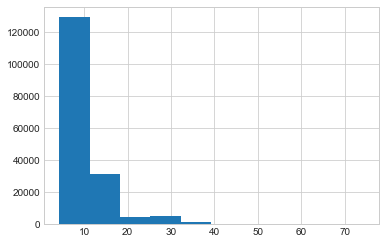

In [202]:
plt.hist(x_val_predictions)

## Phase3: Feature Importance with keras model

Let's see which features contributed to Best models accuracy

In [216]:
def create_model_feat_imp(dropout=0.1):

    model = Sequential()
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam',
                  metrics=[neg_mean_squared_error])
    model.summary()
    return model

In [217]:
best_model = KerasRegressor(
    build_fn=create_model_feat_imp, verbose=1, batch_size=10000, epochs=20)
feat_imp_with_bestmodel = Pipeline([
    ('std_scaler', StandardScaler()),
    ('feature selection', TopFeatureSelector(featureScores, 15)),
    ("predictor", best_model)
])
feat_imp_with_bestmodel.fit(X_train.values, y_train.values)
x_val_predictions = feat_imp_with_bestmodel.predict(X_val.values)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_786 (Dense)            (None, 15)                240       
_________________________________________________________________
dropout_629 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_787 (Dense)            (None, 1)                 16        
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
691786/691786 [==============================] - 10s 14us/step - loss: 138.6315 - neg_mean_squared_error: -138.6315
Epoch 2/20
691786/691786 [==============================] - 2s 3us/step - loss: 108.2146 - neg_mean_squared_error: -108.2146
Epoch 3/20
691786/691786 [==============================] - 2s 3us/step - loss: 81.3424 - neg_mean_squared_error: -81.3424
Epoch 4/20
691786/691786 [=======

In [218]:
feature_importances = feat_imp_with_bestmodel.named_steps.predictor.model.get_weights()
feature_importances

[array([[-0.14129944,  0.14455336,  0.07832222,  0.20066436, -0.11534809,
          0.19633673, -0.78828406,  0.51025367, -0.14043745, -0.11368465,
          0.4083114 ,  0.24402149, -0.8062771 ,  0.4114201 ,  0.22278927],
        [-0.74187756, -0.2513762 ,  0.36416727, -0.2685829 ,  0.06726109,
          0.13667986,  0.7339985 , -0.6228811 ,  0.05308541, -0.22623093,
          0.21784703,  0.37020433,  0.25957724,  0.28068537, -0.12877652],
        [ 0.23928142,  0.11921573,  0.02502397, -0.40896565,  0.06013247,
          0.9995748 ,  0.00654435, -0.34786794, -0.2698878 ,  0.45099914,
         -0.67905664, -0.16720273,  0.688481  ,  0.86743003, -0.03562606],
        [ 0.66476554, -0.4142416 , -0.34879354,  0.496628  , -0.05484698,
          0.78630495,  0.85366297,  0.5279742 ,  0.6681554 ,  0.36649588,
          0.5670089 , -0.5115387 ,  0.7690029 ,  0.76595646, -0.47607678],
        [-0.01113115, -0.07361316,  0.06070418, -0.27086085, -0.12754832,
         -0.5224202 , -0.489575  ,

In [251]:
attributes = ['pickup_jfk_distance', 'dropoff_cluster_3', 'pickup_cluster_3', 'dropoff_ewr_distance', 'dropoff_latitude',
              'haversine', 'dropoff_jfk_distance', 'pickup_ewr_distance', 'pickup_longitude', 'dropoff_longitude',
              'dropoff_cluster_1', 'dropoff_cluster_5', 'pickup_cluster_2', 'airport_trip', 'distance_to_center']
sortedFeatures = sorted(zip(feature_importances[1], attributes), reverse=False)

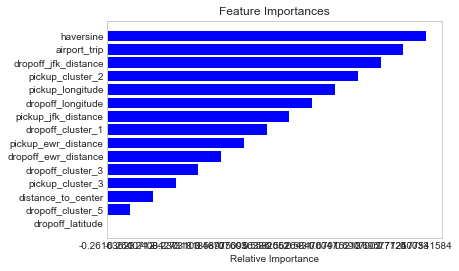

In [252]:
# Plot the feature importances of the Keras model
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.figure()
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

Above graph shows that haversine distance, airport trip, pickup and dropoff clusters contributed heavily towards model accuracy. This results are in-line with our select K-best and backword selection feature selection output.

# Train on the full dataset (55M)

In [221]:
train = feather.read_dataframe('data/data.feather')

In [222]:
train = train.drop(['key'], axis=1)

In [223]:
train.shape

(55423856, 7)

In [224]:
print('Original number of rows: %d' % len(train))
train = train.dropna(how='any', axis='rows')
print('No. of rows after dropping missing values: %d' % len(train))

Original number of rows: 55423856
No. of rows after dropping missing values: 55423480


In [225]:
low = .02
high = .98
quant_train = train.quantile([low, high])
print(quant_train)

      fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0.02  3.50        -74.010293         40.595882       -74.011907           
0.98  46.54       -73.137393         40.799847       -73.484463           

      dropoff_latitude  passenger_count  
0.02  40.577163         1.0              
0.98  40.810172         6.0              


In [226]:
num_attribs = ['pickup_datetime',
               'pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'passenger_count',
               'fare_amount',
               ]

features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'fare_amount', 'hour', 'day',
            'month', 'year', 'haversine', 'distance_to_center',
            'pickup_jfk_distance', 'dropoff_jfk_distance',
            'pickup_ewr_distance', 'dropoff_ewr_distance',
            'pickup_lga_distance', 'dropoff_lga_distance',
            'pickup_cluster', 'dropoff_cluster']

dataprep_pipeline = Pipeline([
    ('data_cleaner', DataCleaner(low=0.02, high=0.98)),
    ('selector', DataFrameSelector(num_attribs)),
    ('attribs_adder', CombinedAttributesAdder(features)),
    ('night_features', CombinedAttributesAdder2()),
    ('data_cleaner2', DataCleaner2()),
])

In [227]:
trainprep = dataprep_pipeline.fit_transform(train)

In [228]:
trainprep.shape

(47917777, 33)

In [229]:
alltrain_y = trainprep['fare_amount']
alltrain_X = trainprep.drop(['fare_amount'], axis=1)

In [230]:
best_model = KerasRegressor(build_fn=create_model,
                            verbose=1, batch_size=10000, epochs=20)
# XGBRegressor(max_depth=3, learning_rate=0.2, n_estimators=100) Phase 2 Best Model
# RandomForestRegressor(random_state=42,n_jobs=-1,max_features=4,n_estimators=30) Phase 1 Best Model
full_pipeline_with_bestmodel = Pipeline([
    ('std_scaler', StandardScaler()),
    ('feature selection', TopFeatureSelector(featureScores, 15)),
    ("predictor", best_model)
])

In [231]:
% % time
full_pipeline_with_bestmodel.fit(alltrain_X.values, alltrain_y.values)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_788 (Dense)            (None, 64)                1024      
_________________________________________________________________
dropout_630 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_789 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_631 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_790 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_632 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_791 (Dense)            (None, 8)                 136       
__________

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature selection', TopFeatureSelector(feature_importances=array([1.09475e+05, 9.15290e+03, 1.09185e+05, 2.84847e+04, 1.13657e+02,
       1.67323e+02, 3.26241e+01, 5.01238e+02, 8.96720e+03, 2.27344e+06,
       4.08945...   k=15)), ('predictor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001ACACB44B00>)])

# Final Test Data Prediction 

Moment of Truth !! <p>
We have experimented and trained our model with the best parameters, and validated against val set.<p>
Now we have to see how it works on actual test data of ~10k rows.

In [241]:
# column index
datetime_ix, lon1_ix, lat1_ix, lon2_ix, lat2_ix = 1, 2, 3, 4, 5

num_attribs = ['key', 'pickup_datetime',
               'pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'passenger_count',
               ]

features = ['key', 'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'hour', 'day',
            'month', 'year', 'haversine', 'distance_to_center',
            'pickup_jfk_distance', 'dropoff_jfk_distance',
            'pickup_ewr_distance', 'dropoff_ewr_distance',
            'pickup_lga_distance', 'dropoff_lga_distance',
            'pickup_cluster', 'dropoff_cluster']

dataprep_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('attribs_adder', CombinedAttributesAdder(features)),
    ('night_features', CombinedAttributesAdder2()),
])

In [242]:
testclean = dataprep_pipeline.fit_transform(test)

In [234]:
testclean.shape

(9914, 33)

In [235]:
testclean.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,...,pickup_cluster_5,dropoff_cluster_0,dropoff_cluster_1,dropoff_cluster_2,dropoff_cluster_3,dropoff_cluster_4,dropoff_cluster_5,airport_trip,night,late_night
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,...,1,0,1,0,0,0,0,0,0,0
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,1,1,2015,...,0,0,1,0,0,0,0,0,0,0
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,5,10,2011,...,1,0,1,0,0,0,0,0,0,0
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,5,12,2012,...,1,0,1,0,0,0,0,0,0,1
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,5,12,2012,...,0,0,1,0,0,0,0,0,0,1


In [236]:
testprep = testclean.drop(['key'], axis=1)

In [237]:
testprep.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month', 'year',
       'haversine', 'distance_to_center', 'pickup_jfk_distance',
       'dropoff_jfk_distance', 'pickup_ewr_distance', 'dropoff_ewr_distance',
       'pickup_lga_distance', 'dropoff_lga_distance', 'pickup_cluster_0',
       'pickup_cluster_1', 'pickup_cluster_2', 'pickup_cluster_3',
       'pickup_cluster_4', 'pickup_cluster_5', 'dropoff_cluster_0',
       'dropoff_cluster_1', 'dropoff_cluster_2', 'dropoff_cluster_3',
       'dropoff_cluster_4', 'dropoff_cluster_5', 'airport_trip', 'night',
       'late_night'],
      dtype='object')

In [238]:
predictions = full_pipeline_with_bestmodel.predict(testprep.values)

9914/9914 [==============================] - 4s 424us/step


(array([4675., 3638.,  818.,  267.,  222.,  196.,   41.,    6.,   16.,
          35.]),
 array([ 4.84362602, 10.08481998, 15.32601395, 20.56720791, 25.80840187,
        31.04959583, 36.29078979, 41.53198376, 46.77317772, 52.01437168,
        57.25556564]),
 <a list of 10 Patch objects>)

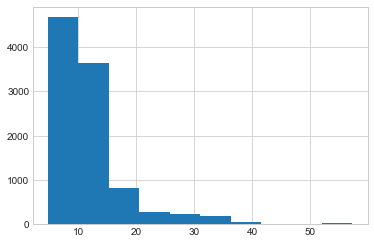

In [239]:
plt.hist(predictions)

## Kaggle Submission

In [240]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': predictions},
    columns=['key', 'fare_amount'])
submission.to_csv('submissionalltrainphase3.csv', index=False)

![title](image/55Mphase3.png)